### Loading libraries

In [1]:
library(vegan)
library(phyloseq)
library(ranacapa)
library(ape)
library(ggplot2)
library(ggpubr)
library(ALDEx2)
library(EnhancedVolcano)
library(reshape2)
library(zCompositions)
library(dplyr)
library(writexl)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4


Attaching package: ‘ggpubr’


The following object is masked from ‘package:ape’:

    rotate


Loading required package: zCompositions

Loading required package: MASS

Loading required package: NADA

Loading required package: survival


Attaching package: ‘NADA’


The following object is masked from ‘package:stats’:

    cor


Loading required package: truncnorm

Loading required package: latticeExtra


Attaching package: ‘latticeExtra’


The following object is masked from ‘package:ggplot2’:

    layer


Loading required package: ggrepel


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following object is masked from ‘package:ape’:

    where


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
dir.create(file.path('../../results/figures'), showWarnings = FALSE)
dir.create(file.path('../../results/figures', 'figure4'), showWarnings = FALSE)
dir.create(file.path('../../results/figures', 'supplementary_figure3'), showWarnings = FALSE)

## All samples

### Load data

In [3]:
# load genus level agglomerated data
ps <- readRDS('../../data/phyloseq/nohost_genus/phyloseq.rds')

# rename otu_data table columns with Bacteria names
tax_data <- data.frame(tax_table(ps))
tax_data['names'] <- tax_data[, 'Genus']
taxa_names(ps) <- tax_data[['names']]

### ALDEx2

In [19]:
# In this cell we subsetthe otu_table to include only samples 
# from participants who have been sampled at the both time points
otu_data <- data.frame(otu_table(ps))
metadata <- data.frame(sample_data(ps))
# split metadata table into 2: 1 only for baseline samples, one for the follow-up
group_baseline <- metadata[metadata[['collection_timepoint']] == 'baseline', ]
group_followup <- metadata[metadata[['collection_timepoint']] == 'follow-up', ]
row.names(group_baseline) <- group_baseline[['host_subject_id']]
row.names(group_followup) <- group_followup[['host_subject_id']]
# select participants from the baseline metadata table who are also included in the follow-up table
# p.s. meaning, such participans were samppled at the follow-up
group_baseline <- group_baseline[row.names(group_followup), ]
row.names(group_baseline) <- group_baseline[['sample_alias']]
row.names(group_followup) <- group_followup[['sample_alias']]
# bind baseline metadata table with selected rows and the follow-up table
metadata_aldex2 <- rbind(group_baseline, group_followup)
# subsample otu_table: select only the samples, which are included in the bind metadata table
otu_data_aldex2 <- otu_data[row.names(metadata_aldex2), ]

In [20]:
# check that we do not have any unpaired samples left
# the result should be 0
sum(table(metadata_aldex2['host_subject_id']) != 2)

[1] 0

In [21]:
# check that samples are in correct order for the paired test
# the result should be 0
sum((metadata_aldex2[metadata_aldex2$collection_timepoint == 'baseline', 'host_subject_id'] ==
     metadata_aldex2[metadata_aldex2$collection_timepoint == 'follow-up', 'host_subject_id']) != TRUE)

[1] 0

In [22]:
# transform to clr
set.seed(24) # setting seed to replicate the results
asv.clr <- aldex.clr(t(as.matrix(otu_data_aldex2)), metadata_aldex2[['collection_timepoint']])

conditions vector supplied

operating in serial mode

computing center with all features



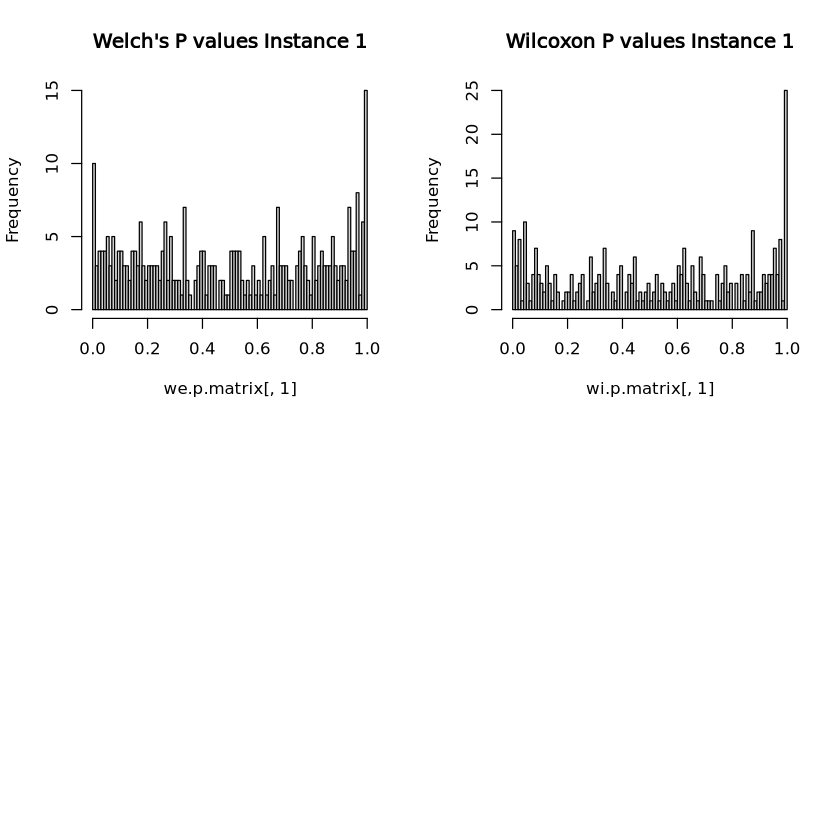

In [23]:
# perform a paired t_test using ALDEx2
p_values_table <- aldex.ttest(asv.clr, paired=TRUE, hist.plot=TRUE)

In [24]:
p_values_summary_table_1 <- cbind(t(data.frame(t(tax_table(ps))))[row.names(p_values_table), 
                                      c('Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus')], 
                        p_values_table)

### Paired Log2Fold

In [25]:
# subset only paired samples
ps_relative <- prune_samples(row.names(metadata_aldex2), ps)
# normalize abundances
ps_relative <- transform_sample_counts(ps_relative, function(x){x / sum(x)})
# eliminate taxa that are harnoured only by one sample
otu_data <- otu_table(ps_relative)
ps_relative <- subset_taxa(ps_relative, as.vector(colSums(otu_data > 0) > 1))
otu_data <- otu_table(ps_relative)
# replace zeors
otu_data <- cmultRepl(otu_data, method = "GBM", z.warning=1)

No. adjusted imputations:  8093 


In [26]:
# ensure the same order of rows between otu table and metadata table
otu_data <- otu_data[row.names(metadata_aldex2), ]

In [27]:
# log2 transform
otu_data_log <- log2(otu_data)
# compute folds
log2fold = otu_data_log[row.names(metadata_aldex2[metadata_aldex2$collection_timepoint == 'follow-up', ]), ] - otu_data_log[row.names(metadata_aldex2[metadata_aldex2$collection_timepoint == 'baseline', ]), ]
log2fold_mean = colMeans(log2fold)


### ALDEx2 Plots

In [28]:
# creare a table with aldex2 results
aldex2_res <- data.frame(padj = p_values_table$wi.eBH, 
                         log2FoldChange = log2fold_mean[row.names(p_values_table)], 
                         lab = row.names(p_values_table),
                         row.names=row.names(p_values_table))
aldex2_res <- aldex2_res[!is.na(aldex2_res$log2FoldChange), ]

# customize point sized for the future volcano plot: 
# size 5 for non-signigicant genera, size 8 - for the significant
aldex2_res$point_size <- 5
aldex2_res[aldex2_res$padj <= 0.05, 'point_size'] <- 8
# order by ascending adjusted p-values
aldex2_res <- aldex2_res[order(aldex2_res$padj), ]
head(aldex2_res[aldex2_res$padj <= 0.05, ])

,padj,log2FoldChange,lab,point_size
,<dbl>,<dbl>,<chr>,<dbl>
Blautia,7.550712e-06,1.326323,Blautia,8
Senegalimassilia,7.595918e-06,1.764713,Senegalimassilia,8
Lachnospiraceae_ND3007_group,8.141890e-06,1.524865,Lachnospiraceae_ND3007_group,8
Marvinbryantia,2.068439e-04,1.417405,Marvinbryantia,8
Lachnospiraceae_FCS020_group,4.019710e-04,1.187960,Lachnospiraceae_FCS020_group,8
Collinsella,1.673273e-03,1.175440,Collinsella,8


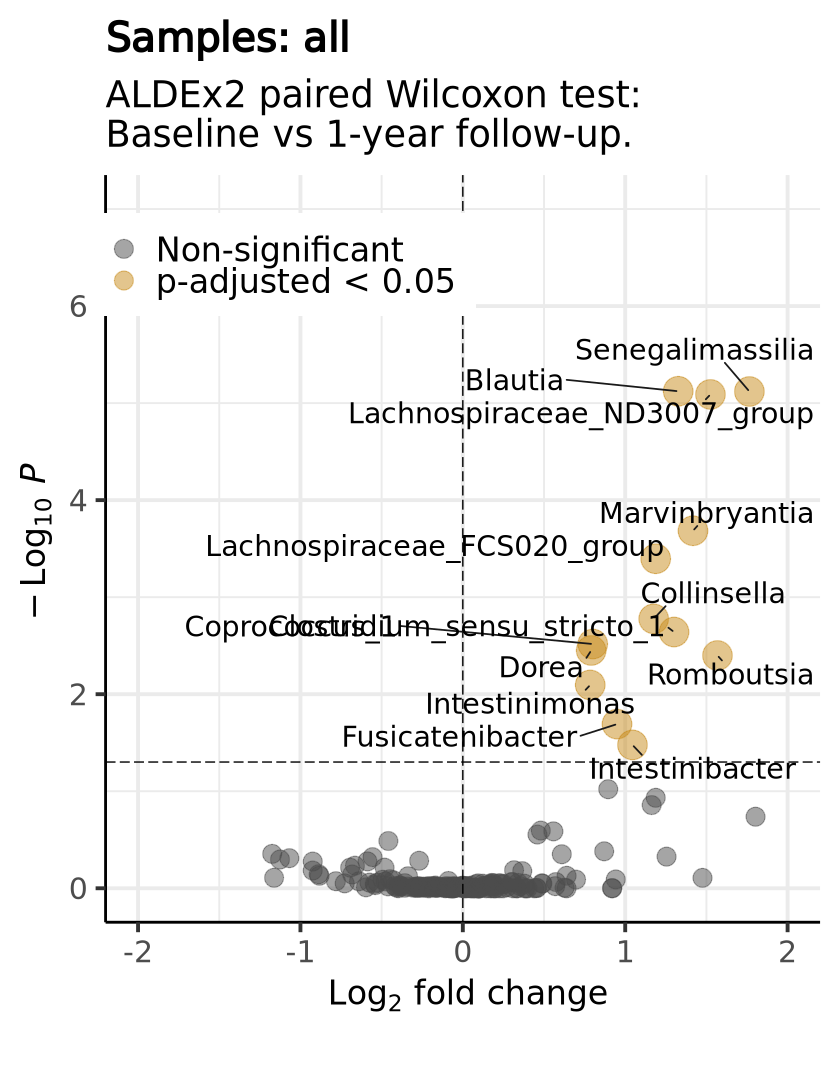

In [29]:
# plot the volcano plot
width = 7
height = 9
options(repr.plot.width=width, repr.plot.height=height)

pCutoff <- 50e-3 # 0.05
FCcutoff <- 1

p <- EnhancedVolcano(aldex2_res,
                lab = aldex2_res[['lab']], 
    x = 'log2FoldChange',
    y = 'padj', 
    xlim=c(-2, 2),
    ylim = c(0, -log10(10e-8)),
    pCutoff = pCutoff,
    FCcutoff = 0,
    labSize = 6,
#     legendPosition = 'right',
    legendPosition = c(0.25, 0.88),
    legendLabSize = 20, 
    legendLabels = c("", "Non-significant", "", "p-adjusted < 0.05"),
    pointSize=aldex2_res$point_size, 
    drawConnectors = TRUE, 
    lengthConnectors = unit(0.2, "npc"),
    arrowheads = FALSE,
    colAlpha=0.5,
    col = c("grey30", "grey30", "royalblue", "#c88c1c" ),
    title = bquote("Samples: all"),
    subtitle = "ALDEx2 paired Wilcoxon test:\nBaseline vs 1-year follow-up.",
    titleLabSize = 24,
    subtitleLabSize = 22,
    caption = "") + #"#b8aa10" 
    theme(axis.title=element_text(size=20))
print(p)

# save the plot
k = 0.3
ggsave(file=file.path('../../results/figures', 'figure4', 'ALDEx2.Wilcoxon_test.volcano_plot.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)

#### Plot relative abundance of the differentially abundant taxa

In [30]:
# select only top 3 significant genera
aldex2_res_signif <- aldex2_res[aldex2_res$padj <= 0.05, ]
otu_data_boxplot <- otu_data[, aldex2_res_signif[1:3, ]$lab]
otu_data_boxplot$grouping <- factor(metadata_aldex2$collection_timepoint, levels=c('baseline', 'follow-up'))
levels(otu_data_boxplot$grouping) <- c("Baseline", "1-year\nfollow-up")
otu_data_boxplot$host_subject_id <- metadata_aldex2$host_subject_id
otu_data_boxplot <- melt(otu_data_boxplot)
levels(otu_data_boxplot$variable) <- c('Blautia', 'Senegalimassilia', 'Lachnospiraceae_ND3007_group')

Using grouping, host_subject_id as id variables



In [31]:
test_pvalues <- aldex2_res_signif[1:3, ]
test_pvalues$group1 <- "Baseline"
test_pvalues$group2 <- "1-year\nfollow-up"
test_pvalues$plabel <- "p.adj < 10⁻⁵"
test_pvalues$variable <- factor(test_pvalues$lab, levels=test_pvalues$lab)

otu_data_max <- filter(otu_data_boxplot, value==max(value), .by=variable)
max_y <- data.frame(value = otu_data_max$value*1.05, row.names=otu_data_max$variable)
test_pvalues$y.position <- max_y[test_pvalues$lab, 'value']
otu_data_max$value <- otu_data_max$value*1.1

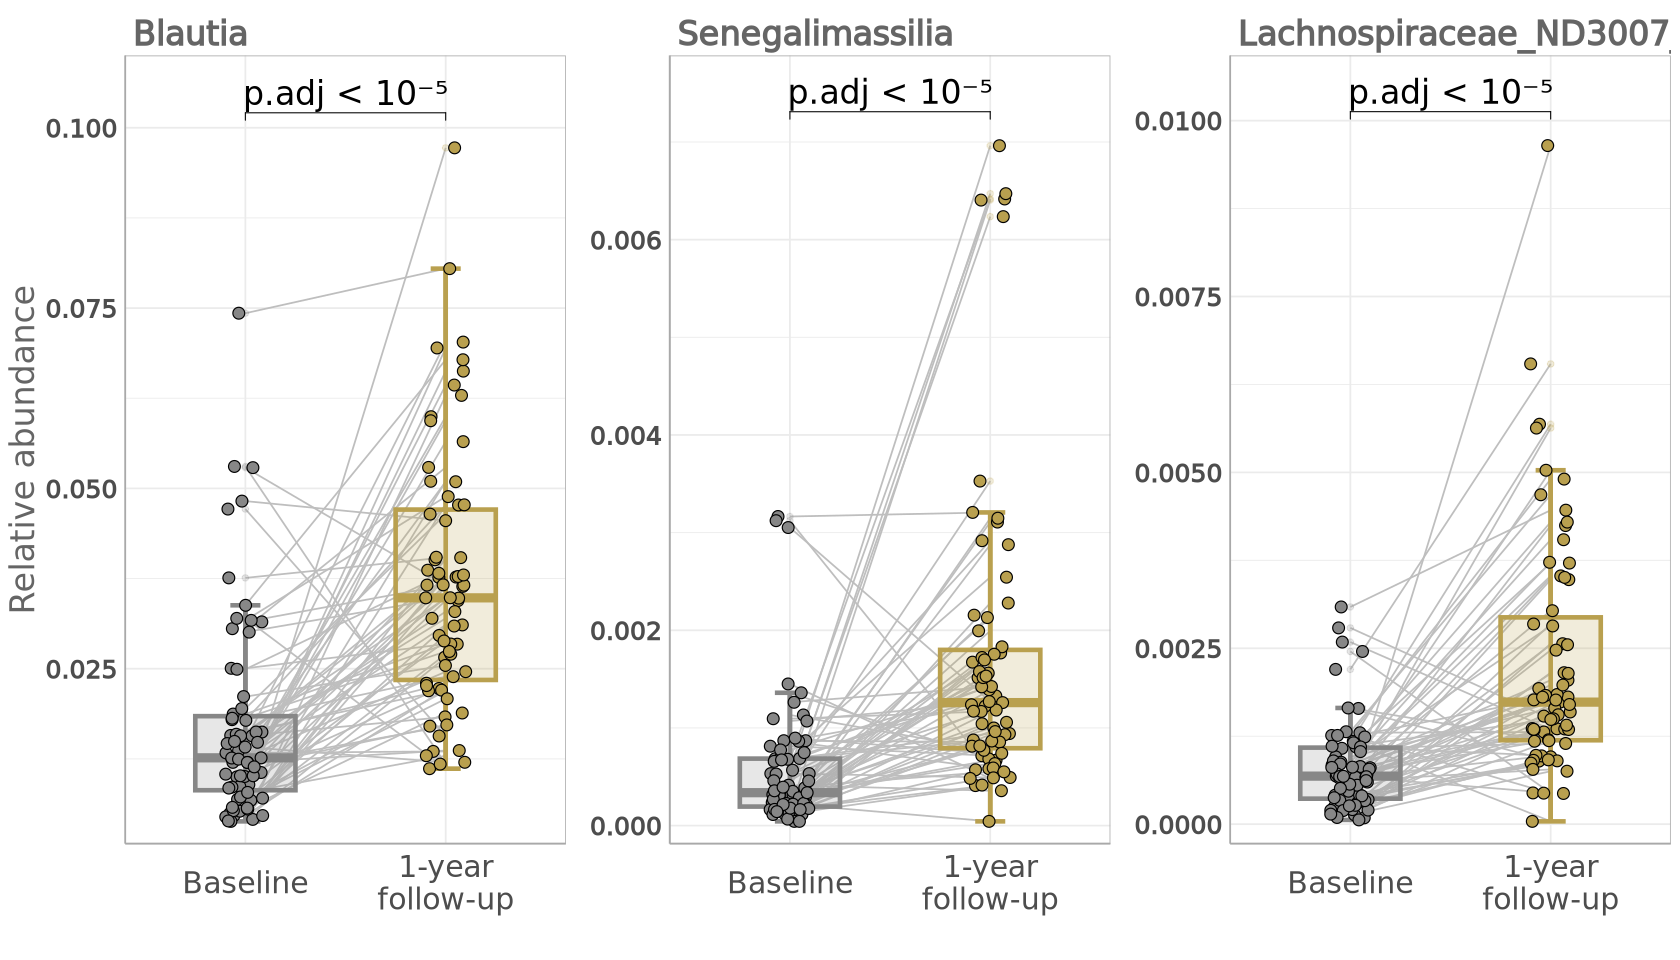

In [32]:
width = 14
height = 8
options(repr.plot.width=width, repr.plot.height=height)
comparisons <- list(c("Baseline", "1-year\nfollow-up"))

p <- ggplot(otu_data_boxplot) + 
# lines connecting pairs of samples
      geom_line(aes(x = grouping, y=value, group = host_subject_id), color = "gray", linewidth = 0.5,) +
# plot error bar first
      stat_boxplot(aes(x=grouping, y=value, color = grouping), 
                   geom = "errorbar", width = 0.15, lwd=1.3) +
# lay boxplot on top
      geom_boxplot(aes(x=grouping, y=value, color = grouping, fill=grouping), 
                   alpha=0.2, lwd=1.3, width=0.5) +
# overlay alpha-diversity values as dots
      geom_jitter(aes(x=grouping, y=value, color = grouping, fill=grouping),
                  size=3, width=0.1, shape=21, color='black')  + 
# add p-value statistics
      stat_pvalue_manual(data=test_pvalues, label='plabel', label.size=7, 
                         tip.length=0.01) +
# build a separate plot for each taxa
      facet_wrap(~variable, scales = "free_y", ncol=4) + 
# change default colors
      scale_fill_manual(values = c('#878787', '#b9a04f')) + 
      scale_colour_manual(values = c('#878787', '#b9a04f')) +
# add titles
      labs(x = "", y = "Relative abundance") +
# expand y limits to fit the p-value statistics into a plot
      scale_y_continuous(expand = expansion(mult = 0.03)) +
# ensure the maximum y axis limit is high enough to fit all the neccesary info 
      geom_blank(data = otu_data_max, aes(x = grouping, y=value, group = host_subject_id)) +
# custom plot design
      theme_minimal() +
      theme(axis.text=element_text(size=15),
            axis.title=element_text(size=20, face="bold"), 
            plot.title=element_text(size=24, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 20, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=18, angle=0, face='plain', vjust = 0.5, hjust=0.5),
            axis.title.y = element_text(color='#656565', face='plain'),
            text = element_text(size = 20, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5),  
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5),  
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(1, "lines"),
            legend.position="none") 

k = 0.3
ggsave(file=file.path('../../results/figures', 'figure4', 
                      'ALDEx2.Wilcoxon_test.boxplots.top3.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
print(p)

In [33]:
# select all significant genera
otu_data_boxplot <- otu_data[, aldex2_res[aldex2_res$padj <= 0.05, ]$lab]
otu_data_boxplot$grouping <- factor(metadata_aldex2$collection_timepoint, levels=c('baseline', 'follow-up'))
levels(otu_data_boxplot$grouping) <- c("Baseline", "1-year\nfollow-up")
otu_data_boxplot$host_subject_id <- metadata_aldex2$host_subject_id
otu_data_boxplot <- melt(otu_data_boxplot)

Using grouping, host_subject_id as id variables



In [34]:
test_pvalues <- aldex2_res[aldex2_res$padj <= 0.05, ]
test_pvalues$group1 <- "Baseline"
test_pvalues$group2 <- "1-year\nfollow-up"

test_pvalues$plabel <- format(test_pvalues$padj, fmt='e', digits=4)
test_pvalues$variable <- factor(test_pvalues$lab, levels=test_pvalues$lab)

otu_data_max <- filter(otu_data_boxplot, value==max(value), .by=variable)
max_y <- data.frame(value = otu_data_max$value*1.05, row.names=otu_data_max$variable)
test_pvalues$y.position <- max_y[test_pvalues$lab, 'value']
otu_data_max$value <- otu_data_max$value*1.1

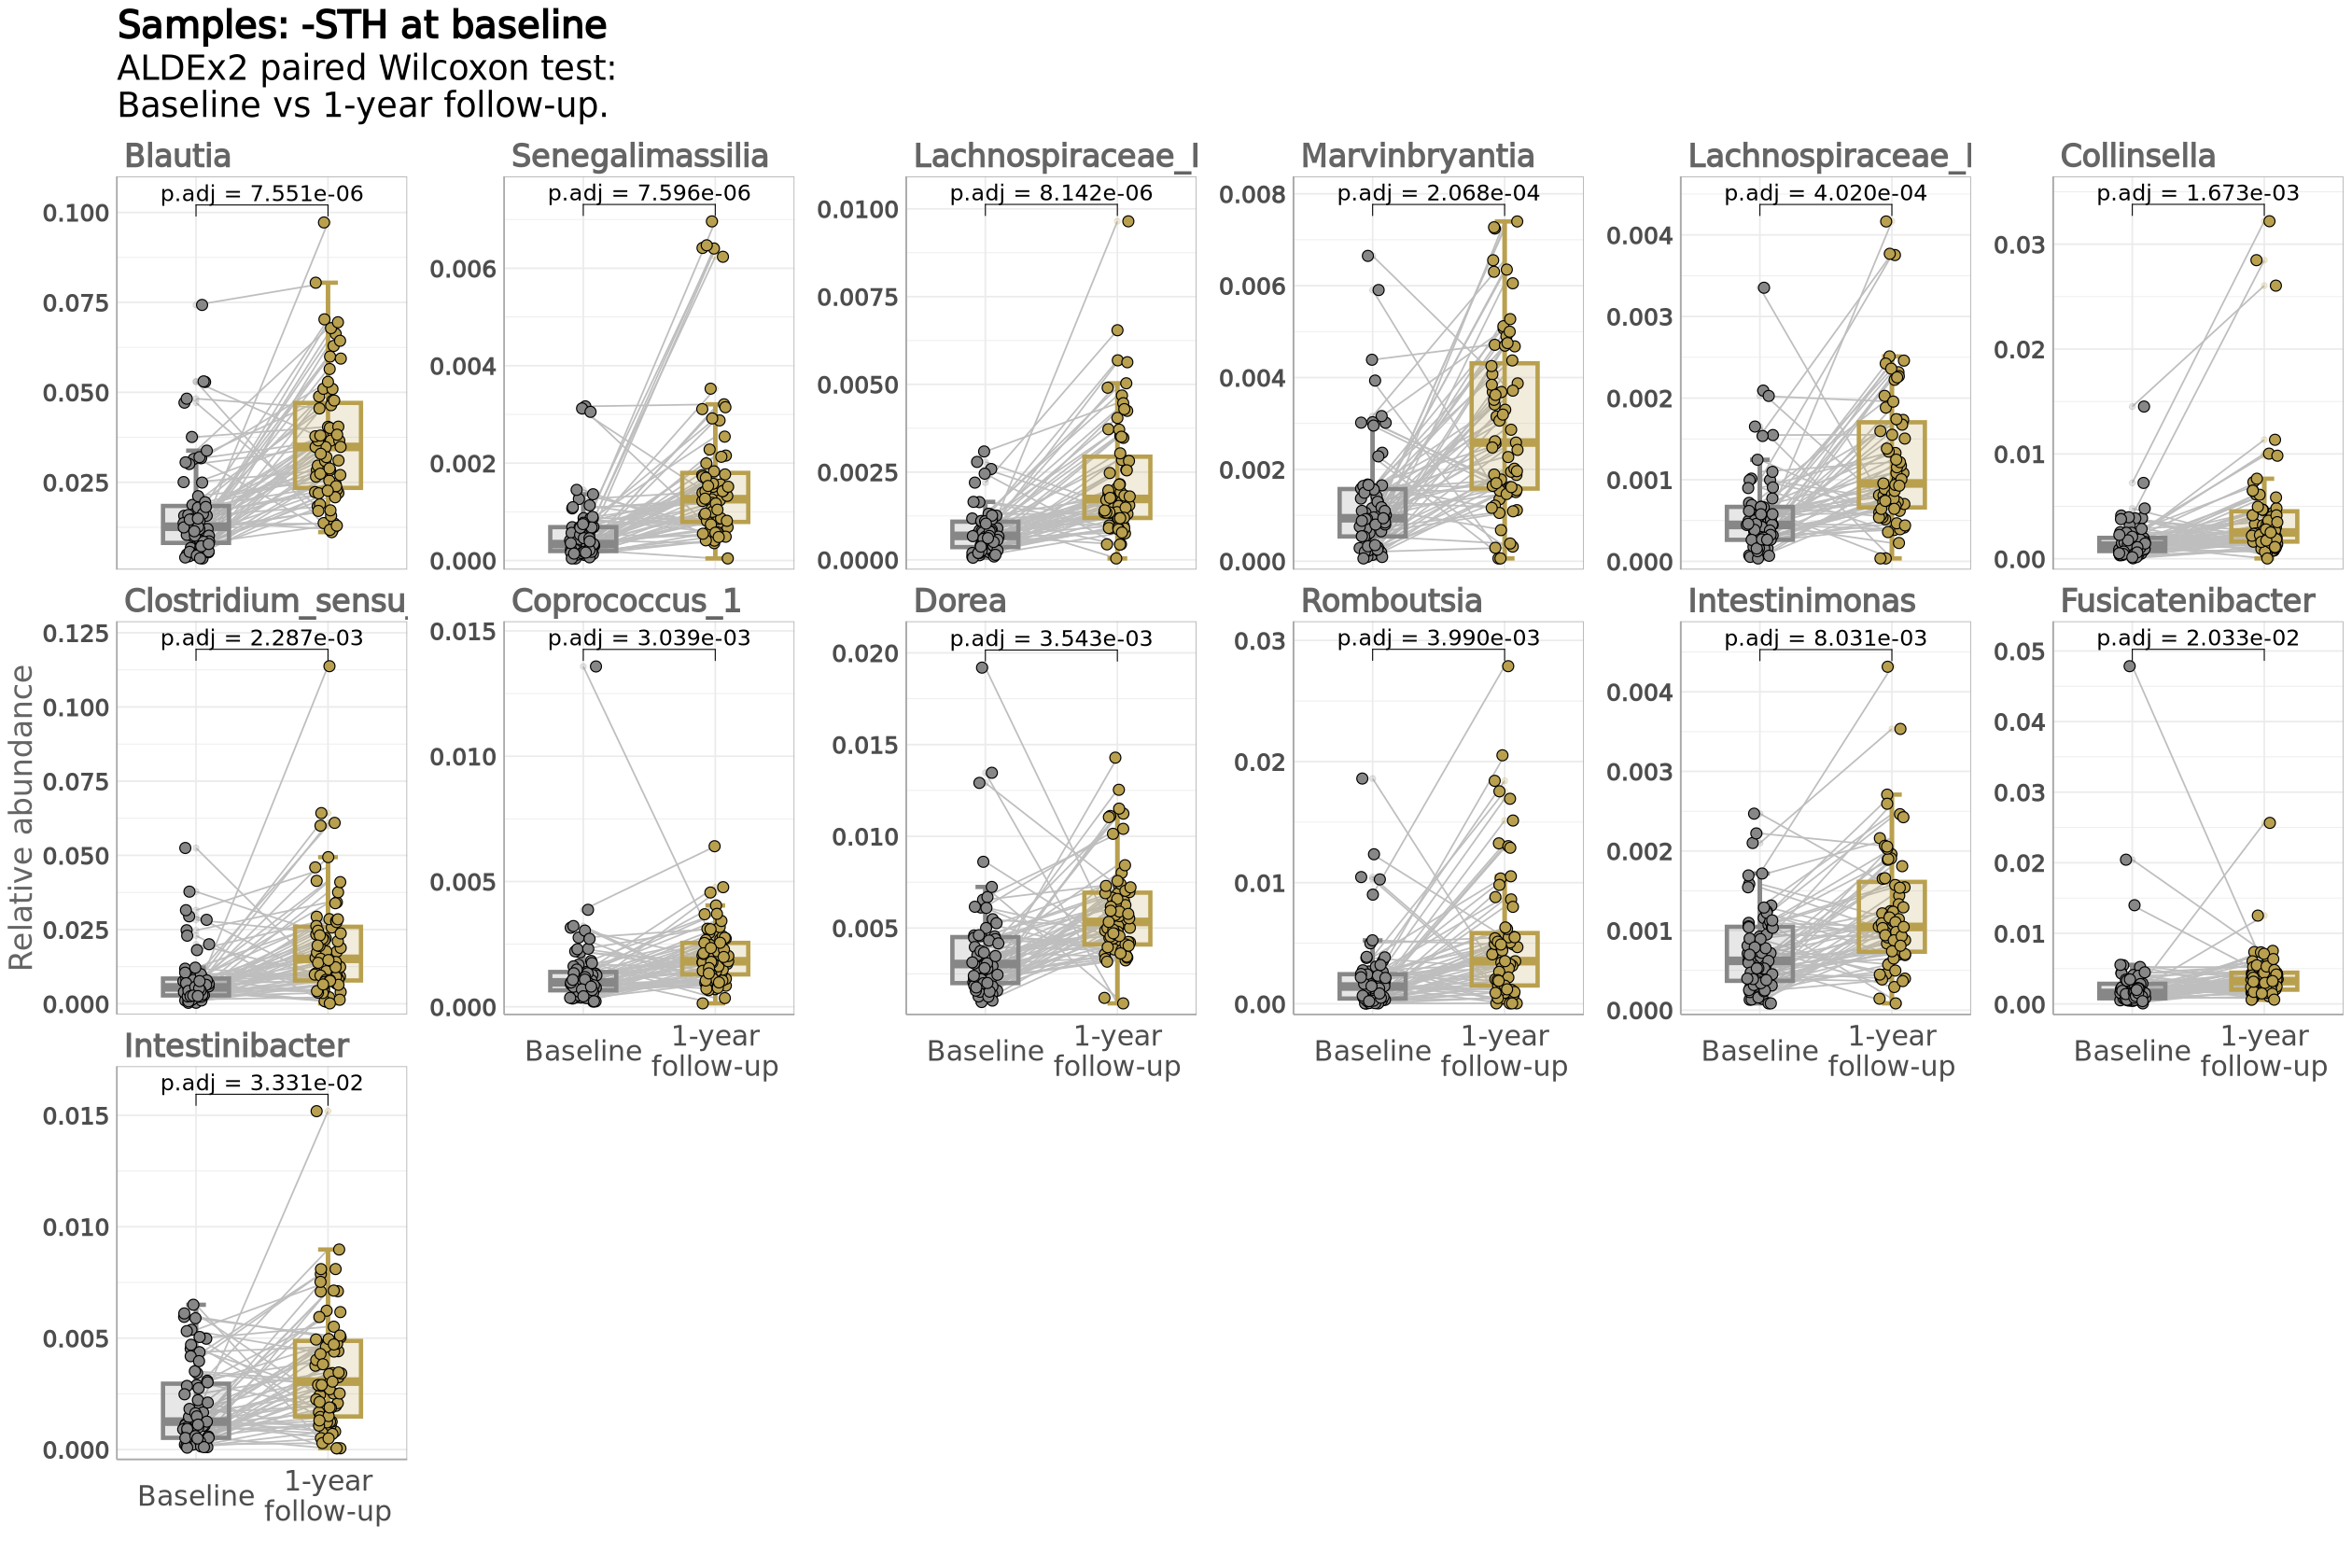

In [35]:
width = 21
height = 14
options(repr.plot.width=width, repr.plot.height=height)
comparisons <- list(c("Baseline", "1-year\nfollow-up"))

p <- ggplot(otu_data_boxplot) + 
# lines connecting pairs of samples
      geom_line(aes(x = grouping, y=value, group = host_subject_id), color = "gray", linewidth = 0.5,) +
# plot error bar first
      stat_boxplot(aes(x=grouping, y=value, color = grouping), 
                   geom = "errorbar", width = 0.15, lwd=1.3) +
# lay boxplot on top
      geom_boxplot(aes(x=grouping, y=value, color = grouping, fill=grouping), 
                   alpha=0.2, lwd=1.3, width=0.5) +
# overlay alpha-diversity values as dots
      geom_jitter(aes(x=grouping, y=value, color = grouping, fill=grouping), 
                  size=3, width=0.1, shape=21, color='black')  + 
# add p-value statistics
      stat_pvalue_manual(data=test_pvalues, label='p.adj = {plabel}', label.size=5, tip.length=0.03) +
# build a separate plot for each taxa
      facet_wrap(~variable, scales = "free_y", ncol=6) + 
# change default colors
      scale_fill_manual(values = c('#878787', '#b9a04f')) + 
      scale_colour_manual(values = c('#878787', '#b9a04f')) +
# add titles
      labs(x = "", y = "Relative abundance", title = "Samples: -STH at baseline",
           subtitle = "ALDEx2 paired Wilcoxon test:\nBaseline vs 1-year follow-up.") +
# ensure the maximum y axis limit is high enough to fit all the neccesary info 
      geom_blank(data = otu_data_max, aes(x = grouping, y=value, group = host_subject_id)) +
# expand y limits to fit the p-value statistics into a plot
      scale_y_continuous(expand = expansion(mult = 0.03)) +
# custom plot design
      theme_minimal() +
      theme(axis.text=element_text(size=15),
            axis.title=element_text(size=20, face="bold"), 
            plot.title=element_text(size=24, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 20, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=18, angle=0, face='plain', vjust = 0.5, hjust=0.5),
            axis.title.y = element_text(color='#656565', face='plain'),
            text = element_text(size = 20, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(1, "lines"),
            legend.position="none") 

k = 0.3
ggsave(file=file.path('../../results/figures', 'supplementary_figure3', 
                      'ALDEx2.Wilcoxon_test.boxplots.all.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
print(p)

## Negative STH at the baseline

### Load data

In [43]:
# load genus level agglomerated data
ps <- readRDS('../../data/phyloseq/nohost_genus/phyloseq.rds')

# rename otu_data table columns with Bacteria names
tax_data <- data.frame(tax_table(ps))

tax_data['names'] <- tax_data[, 'Genus']
taxa_names(ps) <- tax_data[['names']]

In [44]:
# create a new metadata columns which for each sample
# would contain the information about STH status at the baseline
#     baseline_noSTH: a sample was collected at the baseline timepoint and was STH-negative at the baseline
#     followup_noSTH: a sample was collected at the follow-up timepoint and was STH-negative at the baseline
#     baseline_STH: a sample was collected at the baseline timepoint and was STH-positive at the baseline
#     followup_STH: a sample was collected at the follow-up timepoint and was STH-positive at the baseline
STHStatus <- rep('baseline_noSTH', dim(sample_data(ps))[1])
STHStatus_baseline_all <- ((sample_data(ps)[['collection_timepoint']] == 'baseline') & 
                       (sample_data(ps)[['subject_eggcountAnySTHs_baseline']] > 0))
STHStatus[STHStatus_baseline_all] <- 'baseline_STH'
STHStatus_followup <- (sample_data(ps)[['collection_timepoint']] == 'follow-up')
STHStatus[STHStatus_followup] <- 'followup_noSTH'
STHStatus_followup <- ((sample_data(ps)[['collection_timepoint']] == 'follow-up') & 
                    (sample_data(ps)[['subject_eggcountAnySTHs_baseline']] > 0))
STHStatus[STHStatus_followup] <- 'followup_STH'
sample_data(ps)['STHStatus_baseline'] <- STHStatus

### ALDEx2

In [45]:
# select only paired samples and those who were STH-negative at the baseline
otu_data <- data.frame(otu_table(ps))
metadata <- data.frame(sample_data(ps))

# select only baseline samples and among these only those who were STH-negative at the baseline
group_baseline <- metadata[((metadata[['collection_timepoint']] == 'baseline') &
                (metadata[['STHStatus_baseline']] == 'baseline_noSTH')), ]
# select only follow-up samples and among these only those who were STH-negative at the baseline
group_followup <- metadata[((metadata[['collection_timepoint']] == 'follow-up') &
                (metadata[['STHStatus_baseline']] == 'followup_noSTH')), ]
row.names(group_baseline) <- group_baseline[['host_subject_id']]
row.names(group_followup) <- group_followup[['host_subject_id']]
# select samples among the baseline subgroup, collected from the paricipants mentioned in the follow-up table
group_baseline <- group_baseline[row.names(group_followup), ]
row.names(group_baseline) <- group_baseline[['sample_alias']]
row.names(group_followup) <- group_followup[['sample_alias']]
# bind two tables
metadata_aldex2 <- rbind(group_baseline, group_followup)
# subset the otu_table with only sample IDs coming from the bind table
otu_data_aldex2 <- otu_data[row.names(metadata_aldex2), ]

In [46]:
# check the number of samples
dim(otu_data_aldex2)[1]

[1] 86

In [47]:
# check that we do not have any unpaired samples left
# the result should be 0
sum(table(metadata_aldex2['host_subject_id']) != 2)

[1] 0

In [48]:
# check that samples are in correct order for the paired test
# the result should be 0
sum((metadata_aldex2[metadata_aldex2$collection_timepoint == 'baseline', 'host_subject_id'] ==
     metadata_aldex2[metadata_aldex2$collection_timepoint == 'follow-up', 'host_subject_id']) != TRUE)

[1] 0

In [49]:
# transform to clr
set.seed(25) # setting seed to replicate the results
asv.clr <- aldex.clr(t(as.matrix(otu_data_aldex2)), metadata_aldex2[['collection_timepoint']])

conditions vector supplied

operating in serial mode

computing center with all features



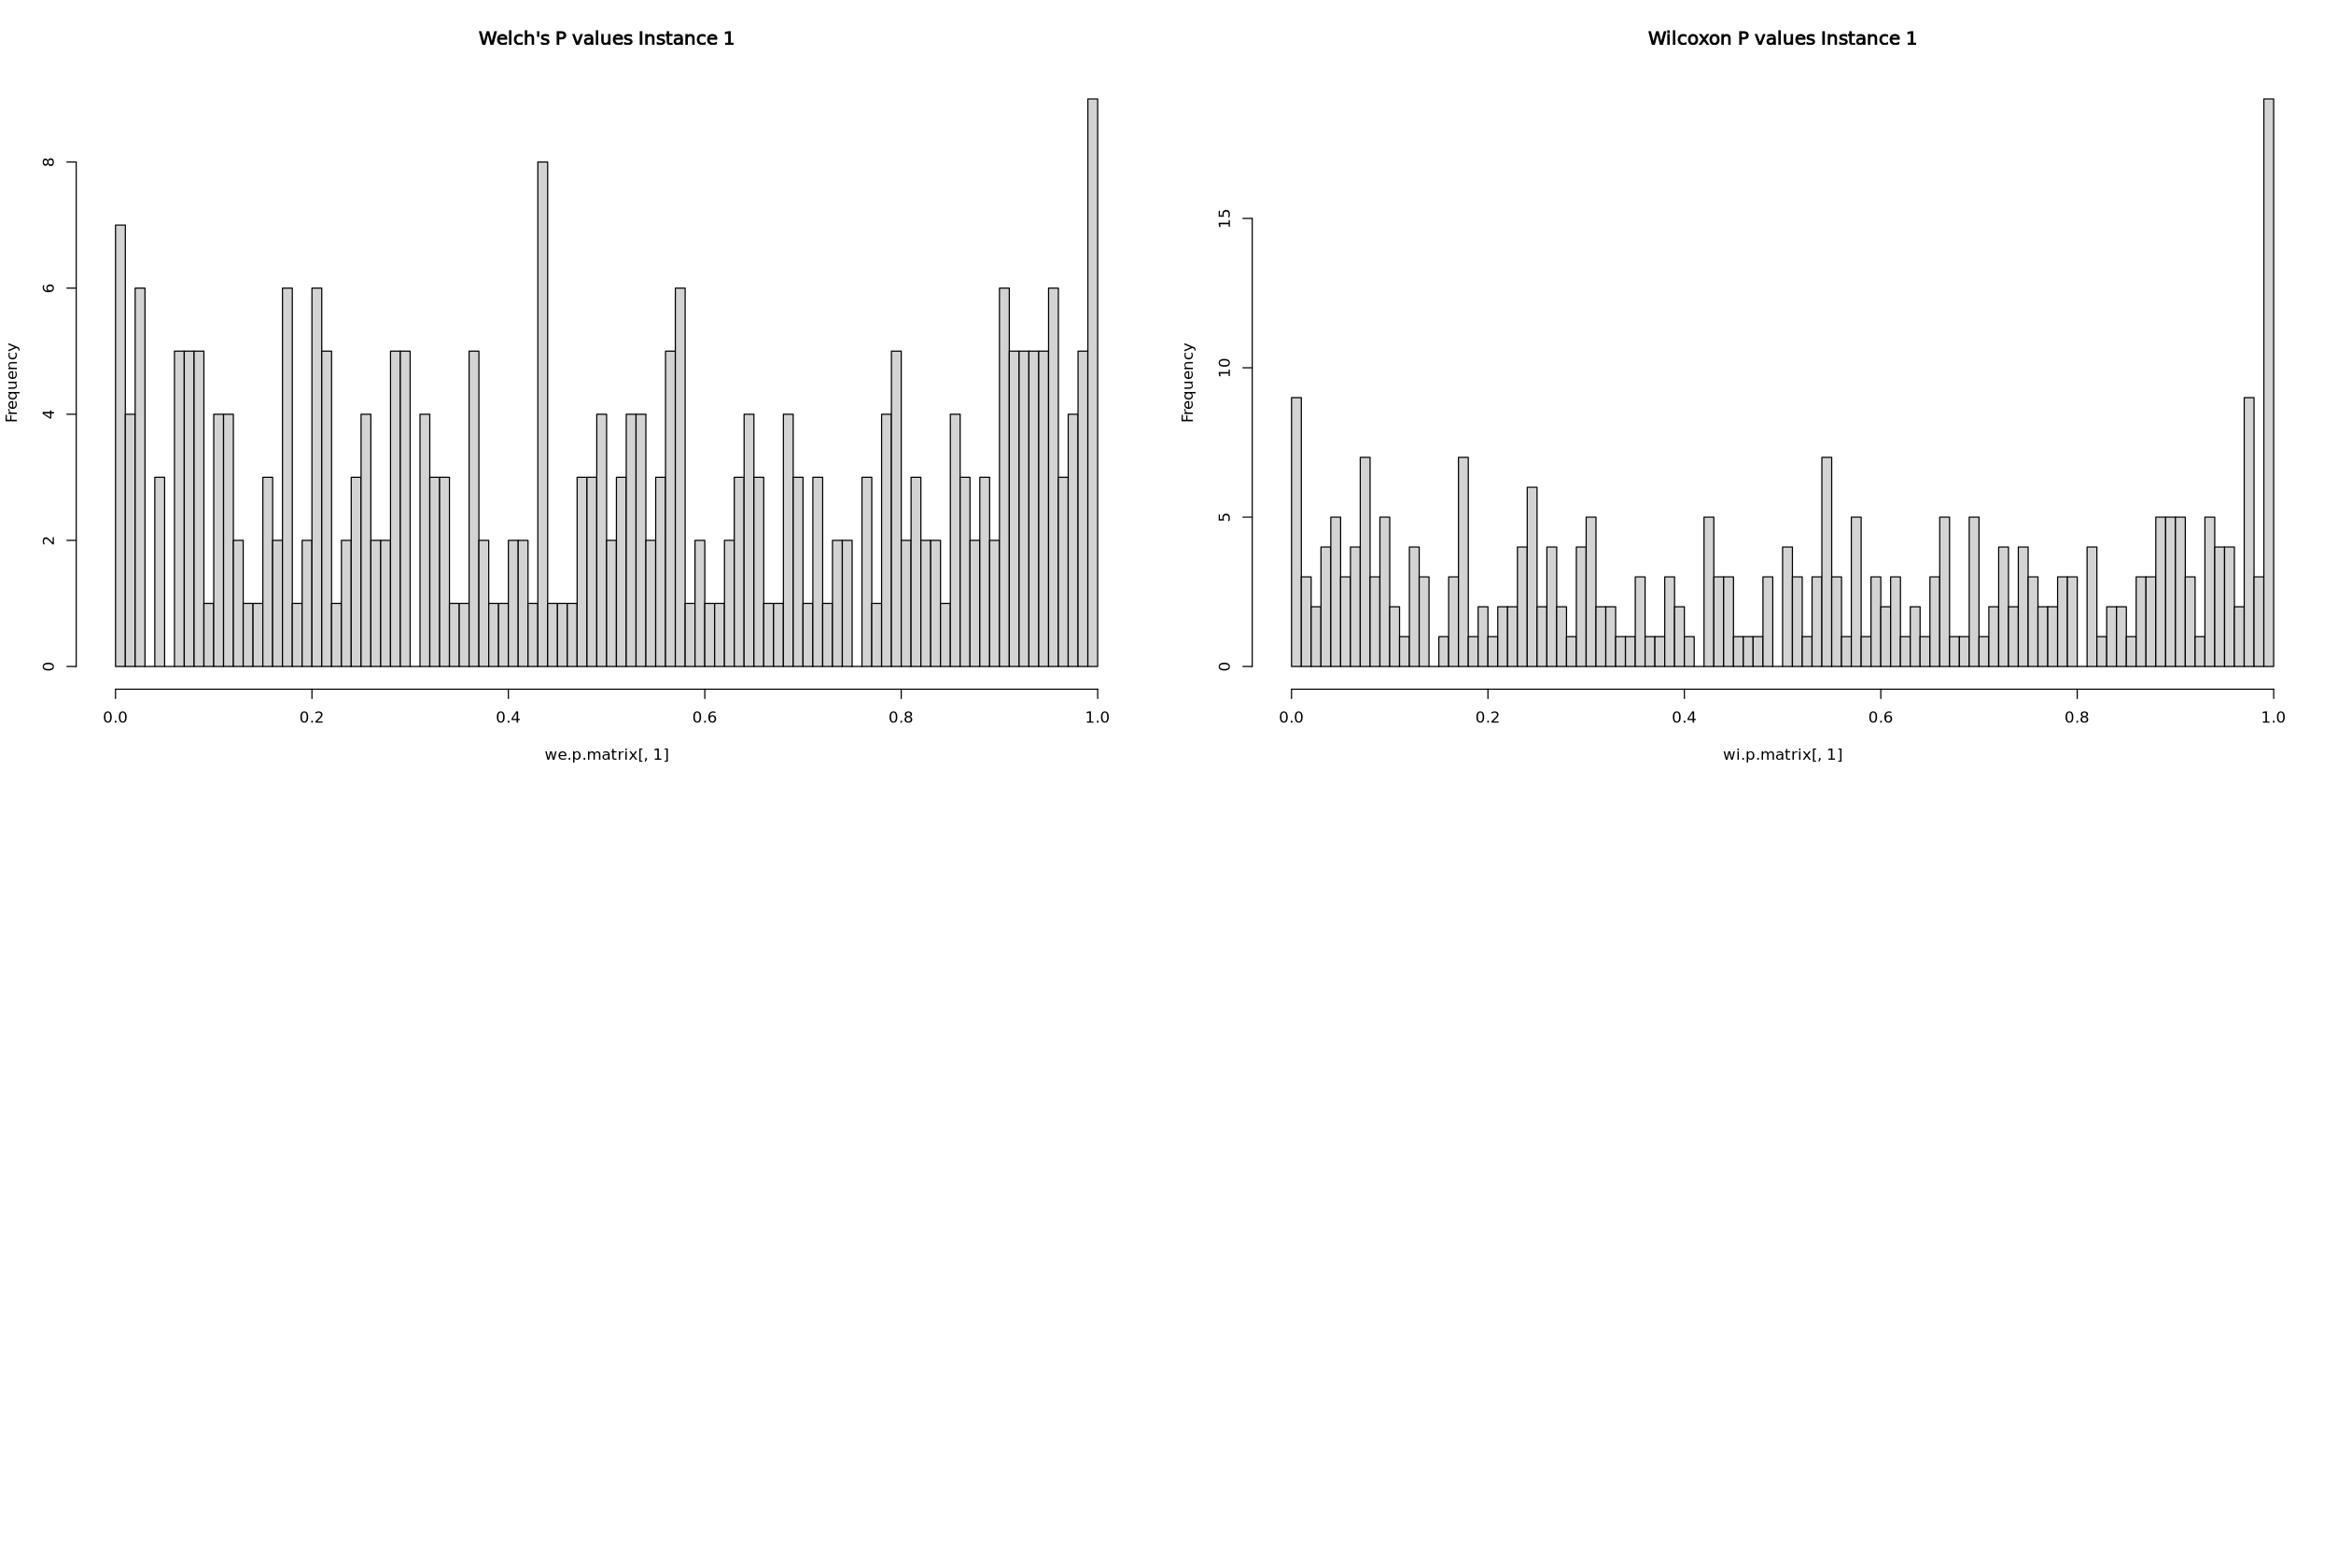

In [50]:
# perform a paired t_test using ALDEx2
p_values_table <- aldex.ttest(asv.clr, paired=TRUE, hist.plot=TRUE)

In [51]:
p_values_summary_table_2 <- cbind(t(data.frame(t(tax_table(ps))))[row.names(p_values_table), 
                                      c('Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus')], 
                        p_values_table)

### Paired Log2Fold

In [52]:
# subset only paired samples
ps_relative <- prune_samples(row.names(metadata_aldex2), ps)
# normalize abundances
ps_relative <- transform_sample_counts(ps_relative, function(x){x / sum(x)})
# eliminate taxa that are harnoured only by one sample
otu_data <- otu_table(ps_relative)
ps_relative <- subset_taxa(ps_relative, as.vector(colSums(otu_data > 0) > 1))
otu_data <- otu_table(ps_relative)
# replace zeors
otu_data <- cmultRepl(otu_data, method = "GBM", z.warning=1)

No. adjusted imputations:  5133 


In [53]:
# ensure the same order of rows between otu table and metadata table
otu_data <- otu_data[row.names(metadata_aldex2), ]

In [54]:
# log2 transform
otu_data_log <- log2(otu_data)
# compute folds
log2fold = otu_data_log[row.names(metadata_aldex2[metadata_aldex2$collection_timepoint == 'follow-up', ]), ] - otu_data_log[row.names(metadata_aldex2[metadata_aldex2$collection_timepoint == 'baseline', ]), ]
log2fold_mean = colMeans(log2fold)


### ALDEx2 Plots

In [55]:
# creare a table with aldex2 results
aldex2_res <- data.frame(padj = p_values_table$wi.eBH, 
                         log2FoldChange = log2fold_mean[row.names(p_values_table)], 
                         lab = row.names(p_values_table),
                         row.names=row.names(p_values_table))
aldex2_res <- aldex2_res[!is.na(aldex2_res$log2FoldChange), ]

# customize point sized for the future volcano plot: 
# size 5 for non-signigicant genera, size 8 - for the significant
aldex2_res$point_size <- 5
aldex2_res[aldex2_res$padj <= 0.05, 'point_size'] <- 8
# order by ascending adjusted p-values
aldex2_res <- aldex2_res[order(aldex2_res$padj), ]
head(aldex2_res[aldex2_res$padj <= 0.05, ])

,padj,log2FoldChange,lab,point_size
,<dbl>,<dbl>,<chr>,<dbl>
Blautia,0.0002521757,1.3030460,Blautia,8
Senegalimassilia,0.0006653716,1.6292405,Senegalimassilia,8
Lachnospiraceae_ND3007_group,0.0018230963,1.4797219,Lachnospiraceae_ND3007_group,8
Marvinbryantia,0.0172151560,1.2975980,Marvinbryantia,8
Clostridium_sensu_stricto_1,0.0310559163,1.3212818,Clostridium_sensu_stricto_1,8
Coprococcus_1,0.0497055597,0.7495036,Coprococcus_1,8


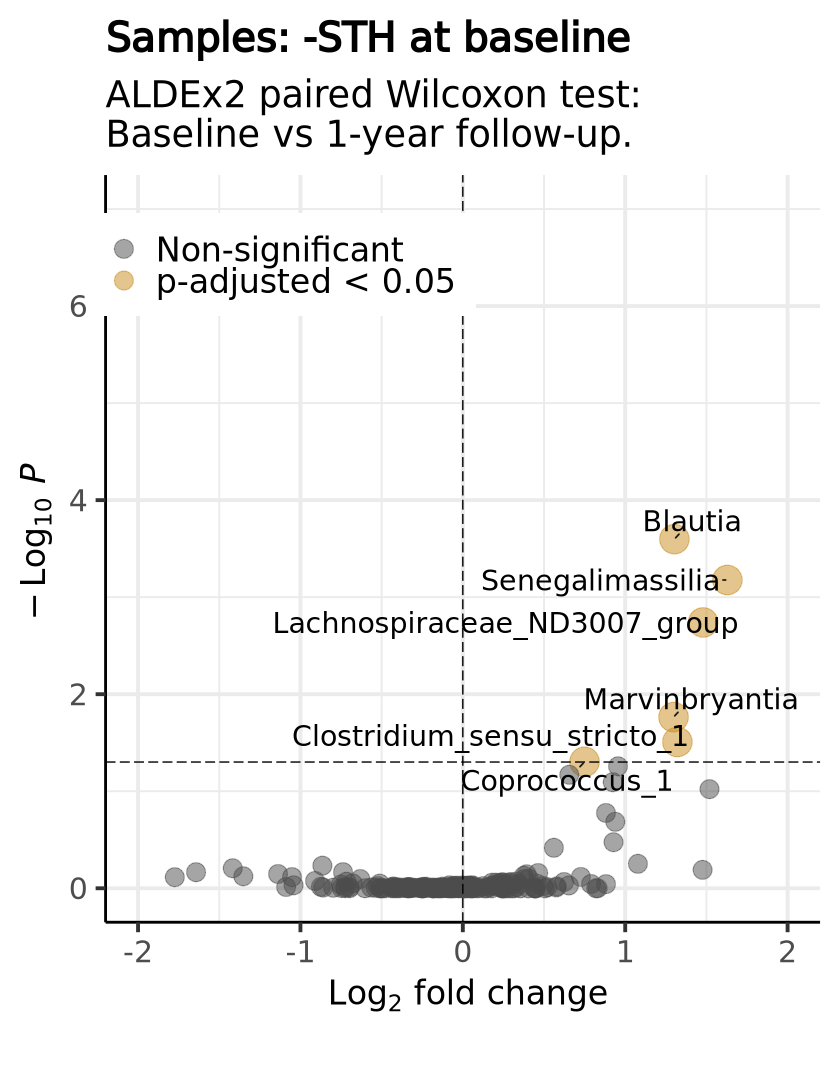

In [56]:
# plot Volacano plot
width = 7
height = 9
options(repr.plot.width=width, repr.plot.height=height)

pCutoff <- 50e-3 # 0.05
FCcutoff <- 1

p <- EnhancedVolcano(aldex2_res,
                lab = aldex2_res[['lab']], 
    x = 'log2FoldChange',
    y = 'padj', 
    xlim=c(-2, 2),
    ylim = c(0, -log10(10e-8)),
    pCutoff = pCutoff,
    FCcutoff = 0,
    labSize = 6,
    legendPosition = c(0.25, 0.88),
    legendLabSize = 20, 
    legendLabels = c("", "Non-significant", "",  "p-adjusted < 0.05"),
    pointSize=aldex2_res$point_size, 
    drawConnectors = TRUE, 
    lengthConnectors = unit(0.2, "npc"),
    arrowheads = FALSE,
    colAlpha=0.5,
    col = c("grey30", "grey30", "royalblue", "#c88c1c" ),
    title = bquote("Samples: -STH at baseline"),
    subtitle = "ALDEx2 paired Wilcoxon test:\nBaseline vs 1-year follow-up.",
    titleLabSize = 24,
    subtitleLabSize = 22,
    caption = "") + 
    theme(axis.title=element_text(size=20))
print(p)

k = 0.3
ggsave(file=file.path('../../results/figures', 'figure4', 'ALDEx2.Wilcoxon_test.noSTH.volcano_plot.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)

#### Plot relative abundance of the differentially abundant taxa

In [57]:
# plot only top 3 significant taxa
aldex2_res_signif <- aldex2_res[aldex2_res$padj <= 0.05, ]
otu_data_boxplot <- otu_data[, aldex2_res_signif[1:3, ]$lab]
otu_data_boxplot$grouping <- factor(metadata_aldex2$collection_timepoint, levels=c('baseline', 'follow-up'))
levels(otu_data_boxplot$grouping) <- c("Baseline", "1-year\nfollow-up")
otu_data_boxplot$host_subject_id <- metadata_aldex2$host_subject_id
otu_data_boxplot <- melt(otu_data_boxplot)
levels(otu_data_boxplot$variable) <- c('Blautia', 'Senegalimassilia', 'Lachnospiraceae_ND3007_group')

Using grouping, host_subject_id as id variables



In [58]:
test_pvalues <- aldex2_res_signif[1:3, ]
test_pvalues$group1 <- "Baseline"
test_pvalues$group2 <- "1-year\nfollow-up"

test_pvalues$plabel <- formatC(test_pvalues$padj, digits=1)
test_pvalues$variable <- factor(test_pvalues$lab, levels=test_pvalues$lab)

otu_data_max <- filter(otu_data_boxplot, value==max(value), .by=variable)
max_y <- data.frame(value = otu_data_max$value*1.05, row.names=otu_data_max$variable)
test_pvalues$y.position <- max_y[test_pvalues$lab, 'value']
otu_data_max$value <- otu_data_max$value*1.1

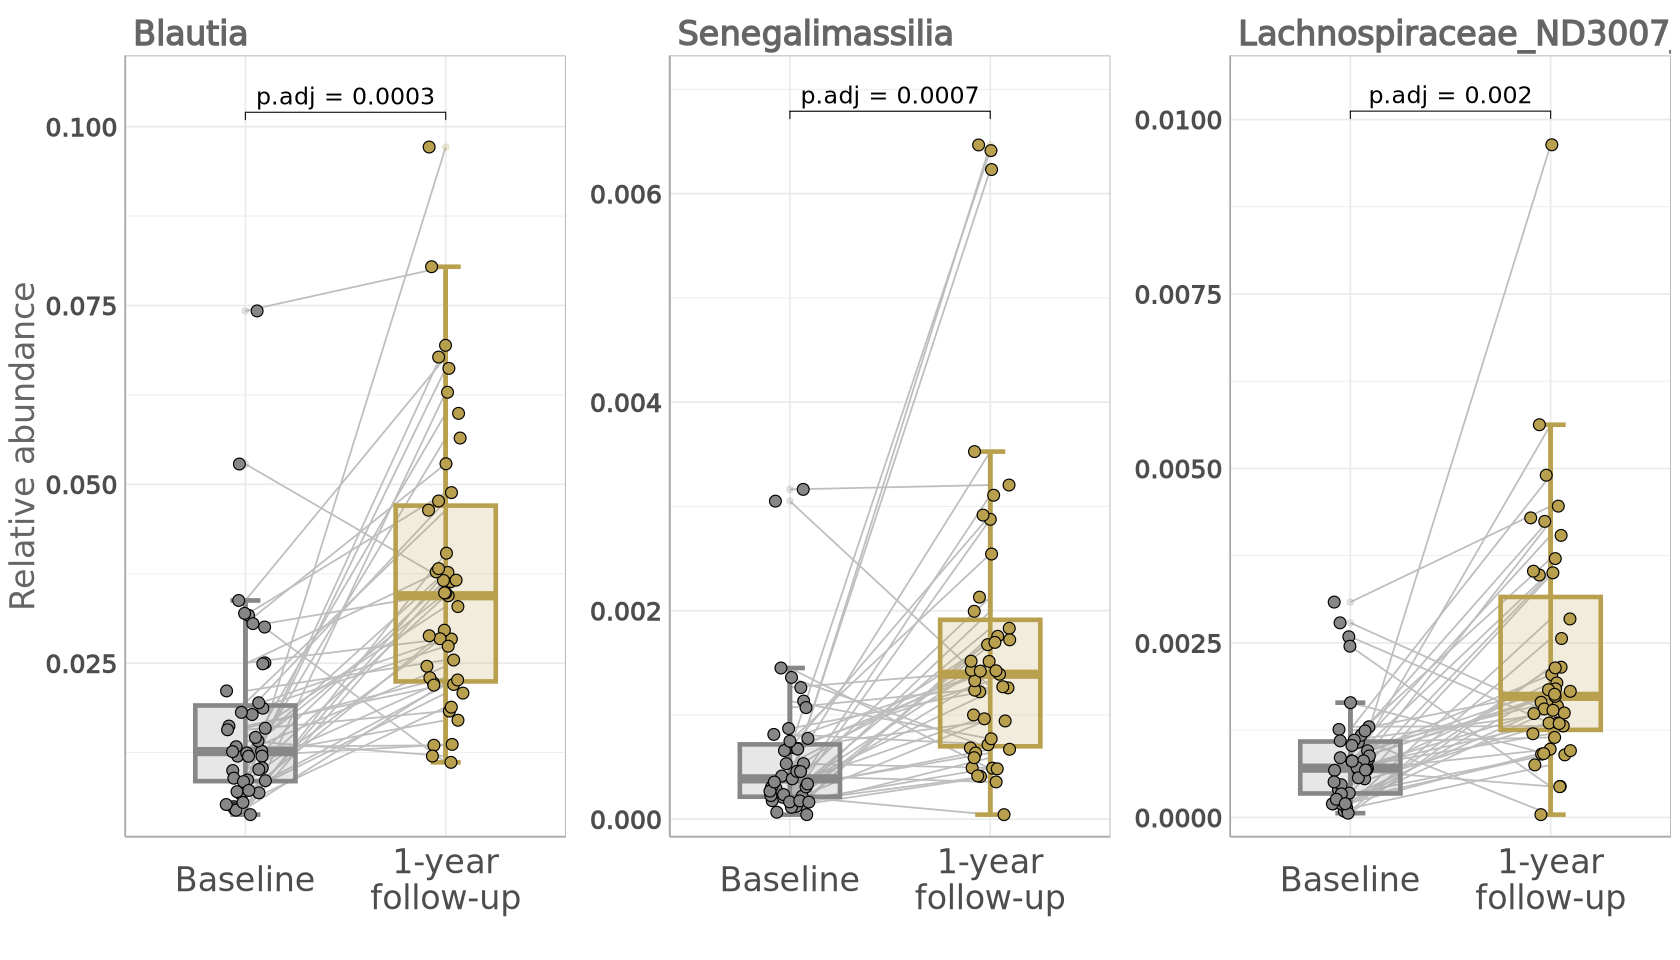

In [59]:
width = 14
height = 8
options(repr.plot.width=width, repr.plot.height=height)
comparisons <- list(c("Baseline", "1-year\nfollow-up"))

p <- ggplot(otu_data_boxplot) + 
# lines connecting pairs of samples
      geom_line(aes(x = grouping, y=value, group = host_subject_id), color = "gray", linewidth = 0.5,) +
# plot error bar first
      stat_boxplot(aes(x=grouping, y=value, color = grouping), 
                   geom = "errorbar", width = 0.15, lwd=1.3) +
# lay boxplot on top
      geom_boxplot(aes(x=grouping, y=value, color = grouping, fill=grouping),
                   alpha=0.2, lwd=1.3, width=0.5) +
# overlay alpha-diversity values as dots
      geom_jitter(aes(x=grouping, y=value, color = grouping, fill=grouping), 
                  size=3, width=0.1, shape=21, color='black')  +
# add p-value statistics
      stat_pvalue_manual(data=test_pvalues, label='p.adj = {plabel}', label.size=5, tip.length=0.01) +
# build a separate plot for each taxa
      facet_wrap(~variable, scales = "free_y", ncol=4) + 
# change default colors
      scale_fill_manual(values = c('#878787', '#b9a04f')) +
      scale_colour_manual(values = c('#878787', '#b9a04f')) +
# add titles
      labs(x = "", y = "Relative abundance") +
# expand y limits to fit the p-value statistics into a plot
      scale_y_continuous(expand = expansion(mult = 0.03)) +
      geom_blank(data = otu_data_max, aes(x = grouping, y=value, group = host_subject_id)) +
# custom plot design
      theme_minimal() +
      theme(axis.text=element_text(size=15),
            axis.title=element_text(size=20, face="bold"), 
            plot.title=element_text(size=24, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 20, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=20, angle=0, face='plain', vjust = 0.5, hjust=0.5),
            axis.title.y = element_text(color='#656565', face='plain'),
            text = element_text(size = 25, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(1, "lines"),
            legend.position="none", 
           ) 

k = 0.3
ggsave(file=file.path('../../results/figures', 'figure4', 'ALDEx2.Wilcoxon_test.noSTH.boxplots.top3.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
print(p)

In [60]:
# select all significant taxa
aldex2_res_signif <- aldex2_res[aldex2_res$padj <= 0.05, ]
otu_data_boxplot <- otu_data[, aldex2_res_signif$lab]
otu_data_boxplot$grouping <- factor(metadata_aldex2$collection_timepoint, levels=c('baseline', 'follow-up'))
levels(otu_data_boxplot$grouping) <- c("Baseline", "1-year\nfollow-up")
otu_data_boxplot$host_subject_id <- metadata_aldex2$host_subject_id
otu_data_boxplot <- melt(otu_data_boxplot)


Using grouping, host_subject_id as id variables



In [61]:
test_pvalues <- aldex2_res_signif
test_pvalues$group1 <- "Baseline"
test_pvalues$group2 <- "1-year\nfollow-up"

test_pvalues$plabel <- formatC(test_pvalues$padj, digits=1)
test_pvalues$variable <- factor(test_pvalues$lab, levels=test_pvalues$lab)

otu_data_max <- filter(otu_data_boxplot, value==max(value), .by=variable)
max_y <- data.frame(value = otu_data_max$value*1.05, row.names=otu_data_max$variable)
test_pvalues$y.position <- max_y[test_pvalues$lab, 'value']
otu_data_max$value <- otu_data_max$value*1.1

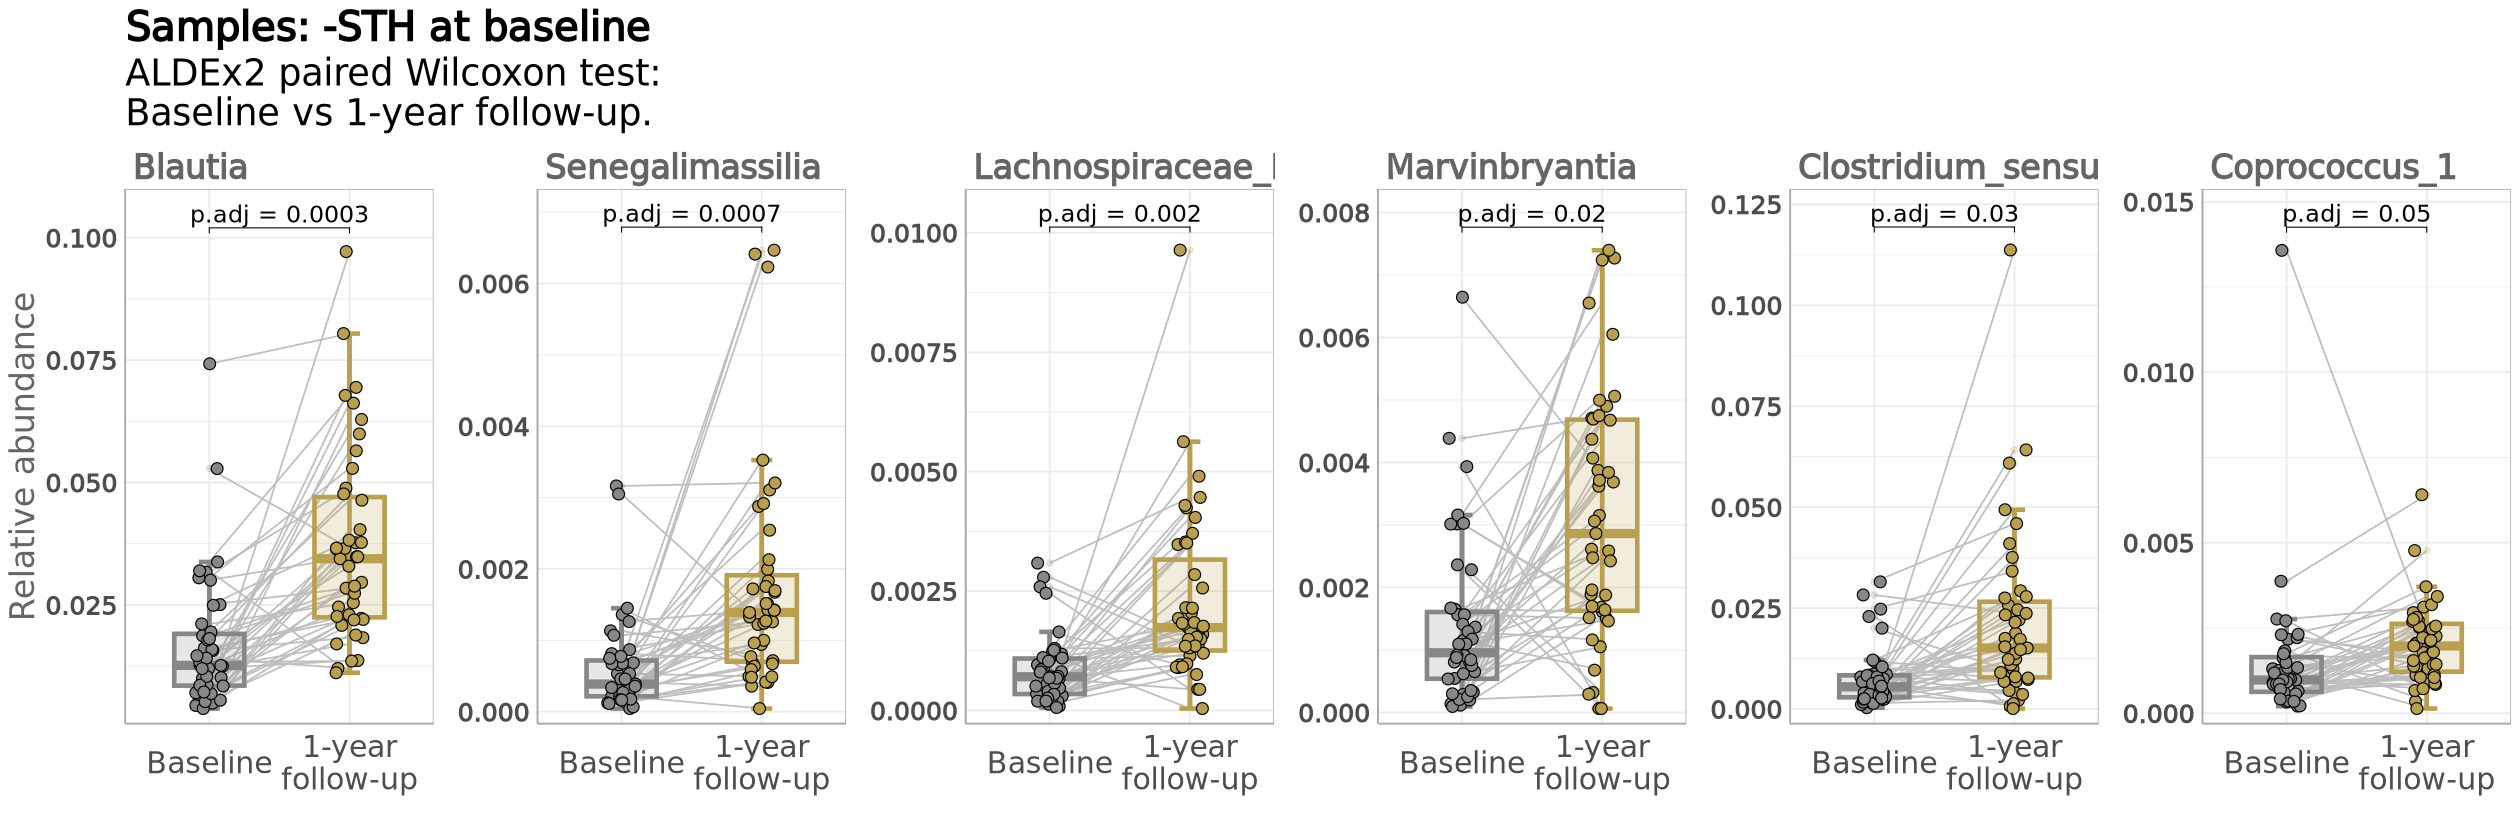

In [62]:
width = 21
height = 7
options(repr.plot.width=width, repr.plot.height=height)
comparisons <- list(c("Baseline", "1-year\nfollow-up"))

p <- ggplot(otu_data_boxplot) + 
# lines connecting pairs of samples
      geom_line(aes(x = grouping, y=value, group = host_subject_id), color = "gray", linewidth = 0.5,) +
# plot error bar first
      stat_boxplot(aes(x=grouping, y=value, color = grouping), geom = "errorbar", width = 0.15, lwd=1.3) +
# lay boxplot on top
      geom_boxplot(aes(x=grouping, y=value, color = grouping, fill=grouping), 
                   alpha=0.2, lwd=1.3, width=0.5) +
# overlay alpha-diversity values as dots
      geom_jitter(aes(x=grouping, y=value, color = grouping, fill=grouping), 
                  size=3, width=0.1, shape=21, color='black')  + 
# add p-value statistics
      stat_pvalue_manual(data=test_pvalues, label='p.adj = {plabel}', label.size=5, tip.length=0.01) +
# build a separate plot for each taxa
      facet_wrap(~variable, scales = "free_y", ncol=6) + 
# change default colors
      scale_fill_manual(values = c('#878787', '#b9a04f')) +
      scale_colour_manual(values = c('#878787', '#b9a04f')) +
# add titles
      labs(x = "", y = "Relative abundance", title = "Samples: -STH at baseline",
           subtitle = "ALDEx2 paired Wilcoxon test:\nBaseline vs 1-year follow-up.") +
# expand y limits to fit the p-value statistics into a plot
      scale_y_continuous(expand = expansion(mult = 0.03)) +
# ensure the maximum y axis limit is high enough to fit all the neccesary info 
      geom_blank(data = otu_data_max, aes(x = grouping, y=value, group = host_subject_id)) +
# custom plot design
      theme_minimal() +
      theme(axis.text=element_text(size=15),
            axis.title=element_text(size=20, face="bold"), 
            plot.title=element_text(size=24, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 20, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=18, angle=0, face='plain', vjust = 0.5, hjust=0.5),
            axis.title.y = element_text(color='#656565', face='plain'),
            text = element_text(size = 25, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(1, "lines"),
            legend.position="none", 
           ) 

k = 0.3
ggsave(file=file.path('../../results/figures', 'supplementary_figure3',
                      'ALDEx2.Wilcoxon_test.noSTH.boxplots.all.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
print(p)

## Positive STH at the baseline

### Load data

In [63]:
# load genus level agglomerated data
ps <- readRDS('../../data/phyloseq/nohost_genus/phyloseq.rds')

# rename otu_data table columns with Bacteria names
tax_data <- data.frame(tax_table(ps))

tax_data['names'] <- tax_data[, 'Genus']
taxa_names(ps) <- tax_data[['names']]

In [64]:
# create a new metadata columns which for each sample
# would contain the information about STH status at the baseline
#     baseline_noSTH: a sample was collected at the baseline timepoint and was STH-negative at the baseline
#     followup_noSTH: a sample was collected at the follow-up timepoint and was STH-negative at the baseline
#     baseline_STH: a sample was collected at the baseline timepoint and was STH-positive at the baseline
#     followup_STH: a sample was collected at the follow-up timepoint and was STH-positive at the baseline
STHStatus <- rep('baseline_noSTH', dim(sample_data(ps))[1])
STHStatus_baseline_all <- ((sample_data(ps)[['collection_timepoint']] == 'baseline') & 
                       (sample_data(ps)[['subject_eggcountAnySTHs_baseline']] > 0))
STHStatus[STHStatus_baseline_all] <- 'baseline_STH'
STHStatus_followup <- (sample_data(ps)[['collection_timepoint']] == 'follow-up')
STHStatus[STHStatus_followup] <- 'followup_noSTH'
STHStatus_followup <- ((sample_data(ps)[['collection_timepoint']] == 'follow-up') & 
                    (sample_data(ps)[['subject_eggcountAnySTHs_baseline']] > 0))
STHStatus[STHStatus_followup] <- 'followup_STH'
sample_data(ps)['STHStatus_baseline'] <- STHStatus

### ALDEx2

In [65]:
# select only paired samples and those who were STH-positive at the baseline
otu_data <- data.frame(otu_table(ps))
metadata <- data.frame(sample_data(ps))
group_baseline <- metadata[((metadata[['collection_timepoint']] == 'baseline') &
                (metadata[['STHStatus_baseline']] == 'baseline_STH')), ]
group_followup <- metadata[((metadata[['collection_timepoint']] == 'follow-up') &
                (metadata[['STHStatus_baseline']] == 'followup_STH')), ]
row.names(group_baseline) <- group_baseline[['host_subject_id']]
row.names(group_followup) <- group_followup[['host_subject_id']]
group_baseline <- group_baseline[row.names(group_followup), ]
row.names(group_baseline) <- group_baseline[['sample_alias']]
row.names(group_followup) <- group_followup[['sample_alias']]
metadata_aldex2 <- rbind(group_baseline, group_followup)
otu_data_aldex2 <- otu_data[row.names(metadata_aldex2), ]

In [66]:
# check the number of samples
dim(otu_data_aldex2)[1]

[1] 48

In [67]:
# check that we do not have any unpaired samples left
# the result should be 0
sum(table(metadata_aldex2['host_subject_id']) != 2)

[1] 0

In [68]:
# check that samples are in correct order for the paired test
# the result should be 0
sum((metadata_aldex2[metadata_aldex2$collection_timepoint == 'baseline', 'host_subject_id'] ==
     metadata_aldex2[metadata_aldex2$collection_timepoint == 'follow-up', 'host_subject_id']) != TRUE)

[1] 0

In [69]:
# transform to clr
set.seed(26)  # setting seed to replicate the results
asv.clr <- aldex.clr(t(as.matrix(otu_data_aldex2)), metadata_aldex2[['collection_timepoint']])

conditions vector supplied

operating in serial mode

computing center with all features



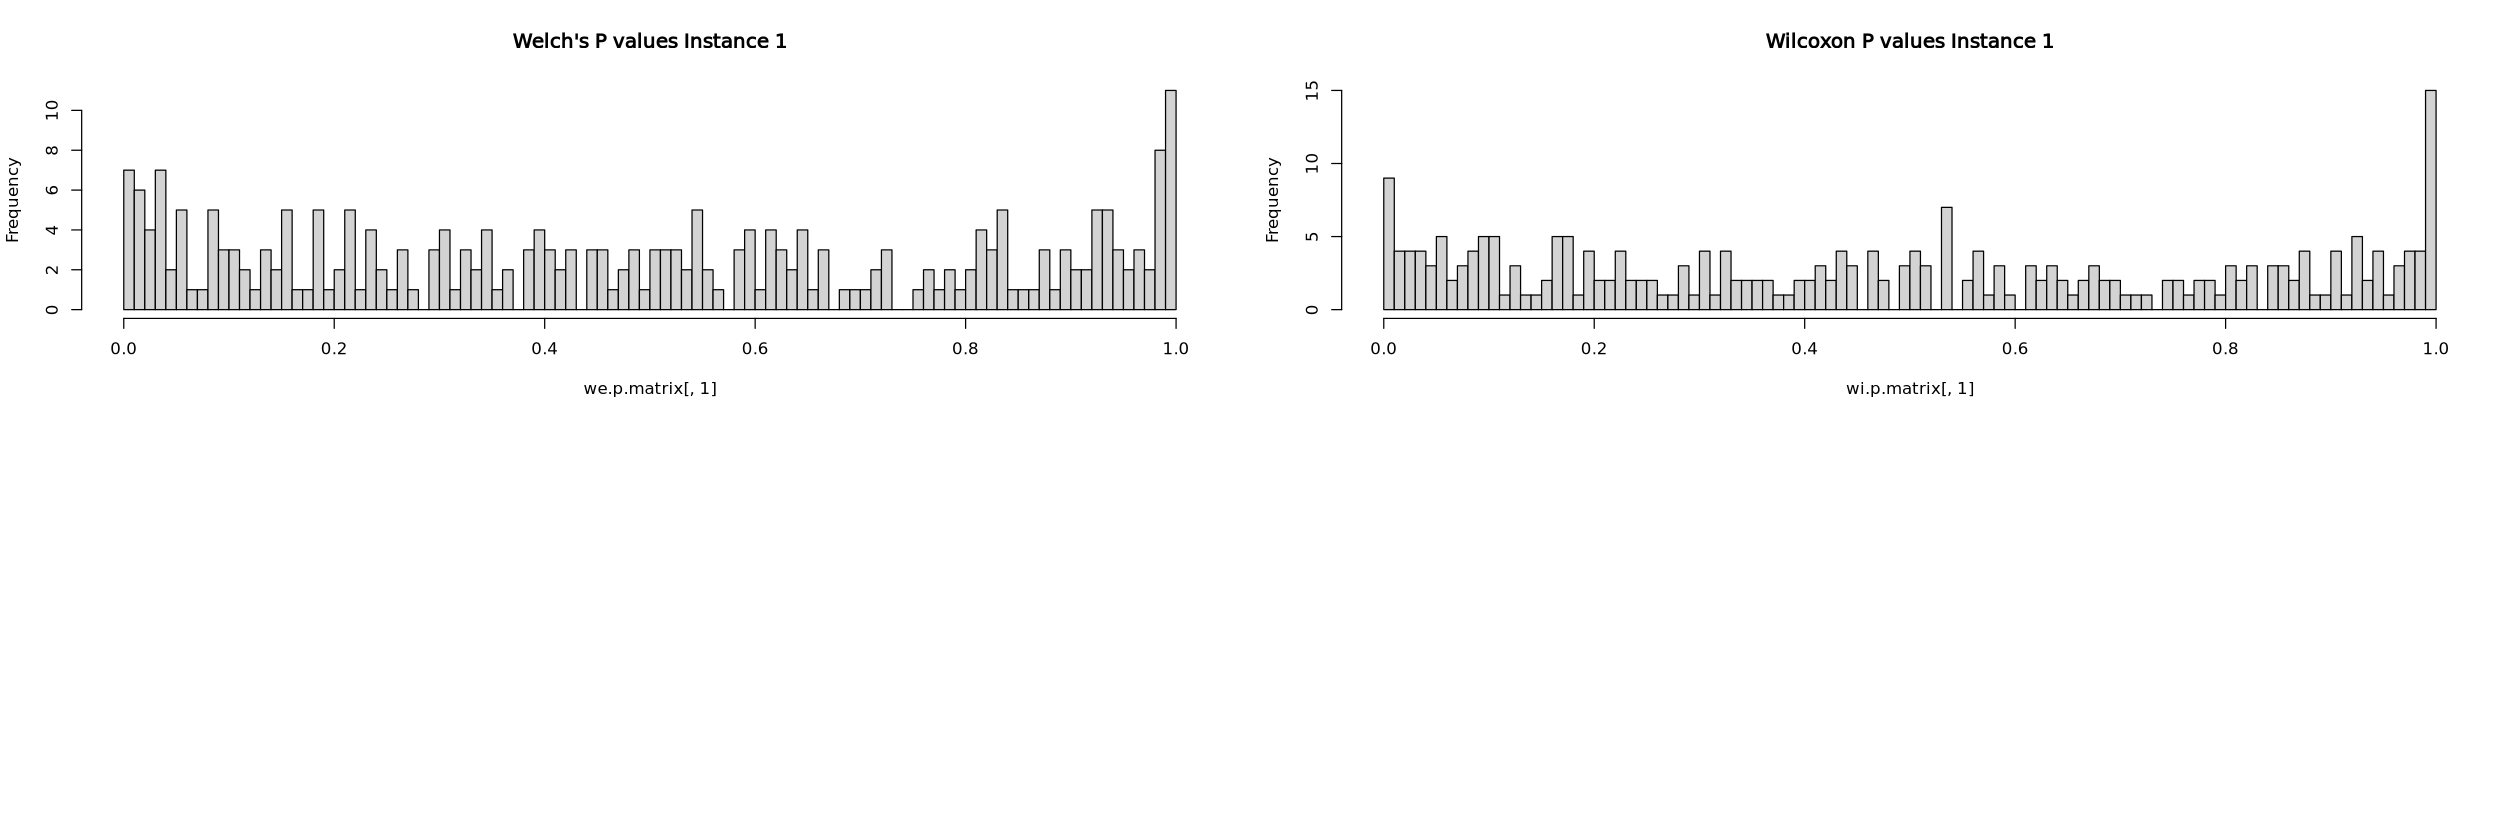

In [70]:
# perform a paired t_test using ALDEx2
p_values_table <- aldex.ttest(asv.clr, paired=TRUE, hist.plot=TRUE)

In [71]:
p_values_summary_table_3 <- cbind(t(data.frame(t(tax_table(ps))))[row.names(p_values_table), 
                                      c('Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus')], 
                        p_values_table)

### Paired Log2Fold

In [72]:
# subset only paired samples
ps_relative <- prune_samples(row.names(metadata_aldex2), ps)
# normalize abundances
ps_relative <- transform_sample_counts(ps_relative, function(x){x / sum(x)})
# eliminate taxa that are harnoured only by one sample
otu_data <- otu_table(ps_relative)
ps_relative <- subset_taxa(ps_relative, as.vector(colSums(otu_data > 0) > 1))
otu_data <- otu_table(ps_relative)
# replace zeros
otu_data <- cmultRepl(otu_data, method = "GBM", z.warning=1)

No. adjusted imputations:  1921 


In [73]:
# ensure the same order of rows between otu table and metadata table
otu_data <- otu_data[row.names(metadata_aldex2), ]

In [74]:
# log2 transform
otu_data_log <- log2(otu_data)
# compute folds
log2fold = otu_data_log[row.names(metadata_aldex2[metadata_aldex2$collection_timepoint == 'follow-up', ]), ] - otu_data_log[row.names(metadata_aldex2[metadata_aldex2$collection_timepoint == 'baseline', ]), ]
log2fold_mean = colMeans(log2fold)


### ALDEx2 Plots

In [75]:
# creare a table with aldex2 results
aldex2_res <- data.frame(padj = p_values_table$wi.eBH, 
                         log2FoldChange = log2fold_mean[row.names(p_values_table)], 
                         lab = row.names(p_values_table),
                         row.names=row.names(p_values_table))
aldex2_res <- aldex2_res[!is.na(aldex2_res$log2FoldChange), ]

# customize point sized for the future volcano plot: 
# size 5 for non-signigicant genera, size 8 - for the significant
aldex2_res$point_size <- 5
aldex2_res[aldex2_res$padj <= 0.05, 'point_size'] <- 8
# order by ascending adjusted p-values
aldex2_res <- aldex2_res[order(aldex2_res$padj), ]
head(aldex2_res[aldex2_res$padj <= 0.05, ])

,padj,log2FoldChange,lab,point_size
,<dbl>,<dbl>,<chr>,<dbl>
Lachnospiraceae_ND3007_group,0.01307883,1.613513,Lachnospiraceae_ND3007_group,8
Senegalimassilia,0.01654384,1.982420,Senegalimassilia,8
Lachnospiraceae_FCS020_group,0.01720110,1.625496,Lachnospiraceae_FCS020_group,8
Collinsella,0.01886815,1.709842,Collinsella,8
Intestinimonas,0.04075298,1.181431,Intestinimonas,8
Marvinbryantia,0.04222740,1.642914,Marvinbryantia,8


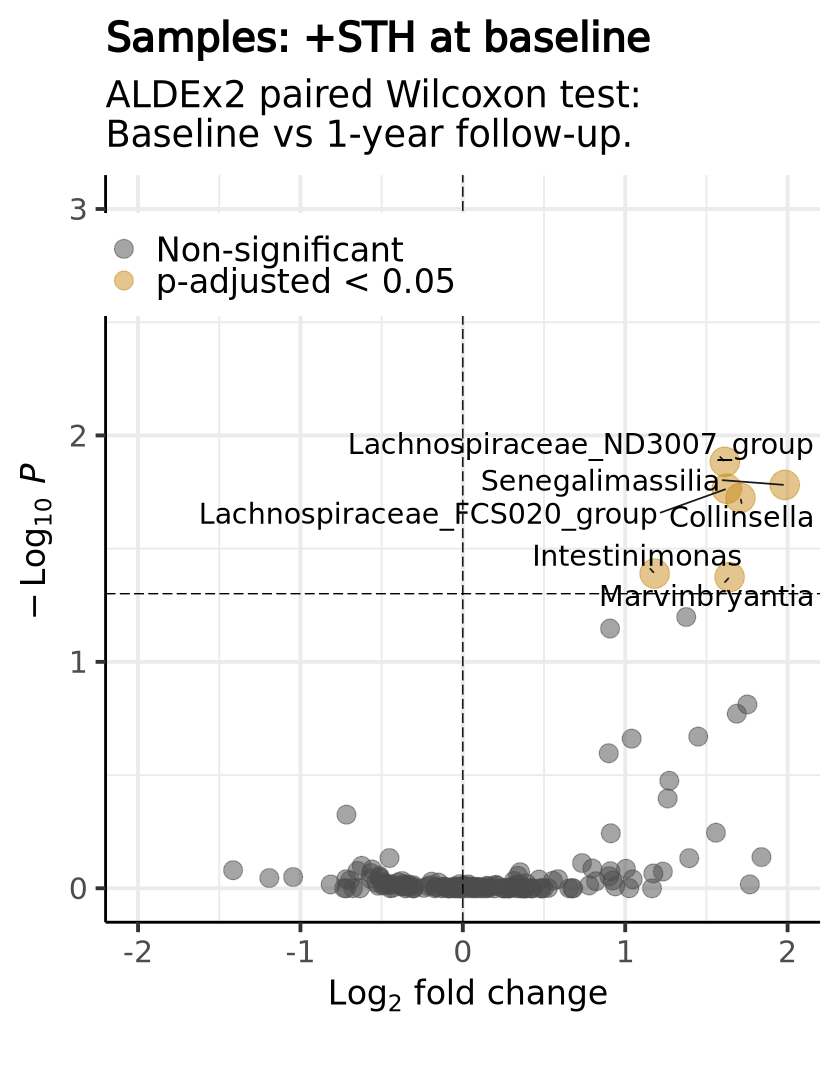

In [76]:
# volcano plot
width = 7
height = 9
options(repr.plot.width=width, repr.plot.height=height)

pCutoff <- 50e-3 # 0.05
FCcutoff <- 1

p <- EnhancedVolcano(aldex2_res,
                lab = aldex2_res[['lab']], 
    x = 'log2FoldChange',
    y = 'padj', 
    xlim=c(-2, 2),
    ylim = c(0, -log10(10e-4)),
    pCutoff = pCutoff,
    FCcutoff = 0,
    labSize = 6,
    legendPosition = c(0.25, 0.88),
    legendLabSize = 20, 
    legendLabels = c("", "Non-significant", "", "p-adjusted < 0.05"),
    pointSize=aldex2_res$point_size, 
    drawConnectors = TRUE, 
    lengthConnectors = unit(0.2, "npc"),
    arrowheads = FALSE,
    colAlpha=0.5,
    col = c("grey30", "grey30", "royalblue", "#c88c1c" ),
    title = bquote("Samples: +STH at baseline"), 
    subtitle = "ALDEx2 paired Wilcoxon test:\nBaseline vs 1-year follow-up.",
    titleLabSize = 24,
    subtitleLabSize = 22,
    caption = "") + 
    theme(axis.title=element_text(size=20))
print(p)

k = 0.3
ggsave(file=file.path('../../results/figures', 'figure4', 'ALDEx2.Wilcoxon_test.STH.volcano_plot.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)

#### Plot relative abundance of the differentially abundant taxa

In [77]:
# plot only top 3 differentially abundant taxa
aldex2_res_signif <- aldex2_res[aldex2_res$padj <= 0.05, ]
otu_data_boxplot <- otu_data[, aldex2_res_signif[1:3, ]$lab]
otu_data_boxplot$grouping <- factor(metadata_aldex2$collection_timepoint, levels=c('baseline', 'follow-up'))
levels(otu_data_boxplot$grouping) <- c("Baseline", "1-year\nfollow-up")
otu_data_boxplot$host_subject_id <- metadata_aldex2$host_subject_id
otu_data_boxplot <- melt(otu_data_boxplot)
levels(otu_data_boxplot$variable) <- c('Lachnospiraceae_FCS020_group', 
                                       'Senegalimassilia', 'Lachnospiraceae_ND3007_group')

Using grouping, host_subject_id as id variables



In [78]:
test_pvalues <- aldex2_res_signif[1:3, ]
test_pvalues$group1 <- "Baseline"
test_pvalues$group2 <- "1-year\nfollow-up"

test_pvalues$plabel <- formatC(test_pvalues$padj, digits=2)
test_pvalues$variable <- factor(test_pvalues$lab, levels=test_pvalues$lab)

otu_data_max <- filter(otu_data_boxplot, value==max(value), .by=variable)
max_y <- data.frame(value = otu_data_max$value*1.05, row.names=otu_data_max$variable)
test_pvalues$y.position <- max_y[test_pvalues$lab, 'value']
otu_data_max$value <- otu_data_max$value*1.1

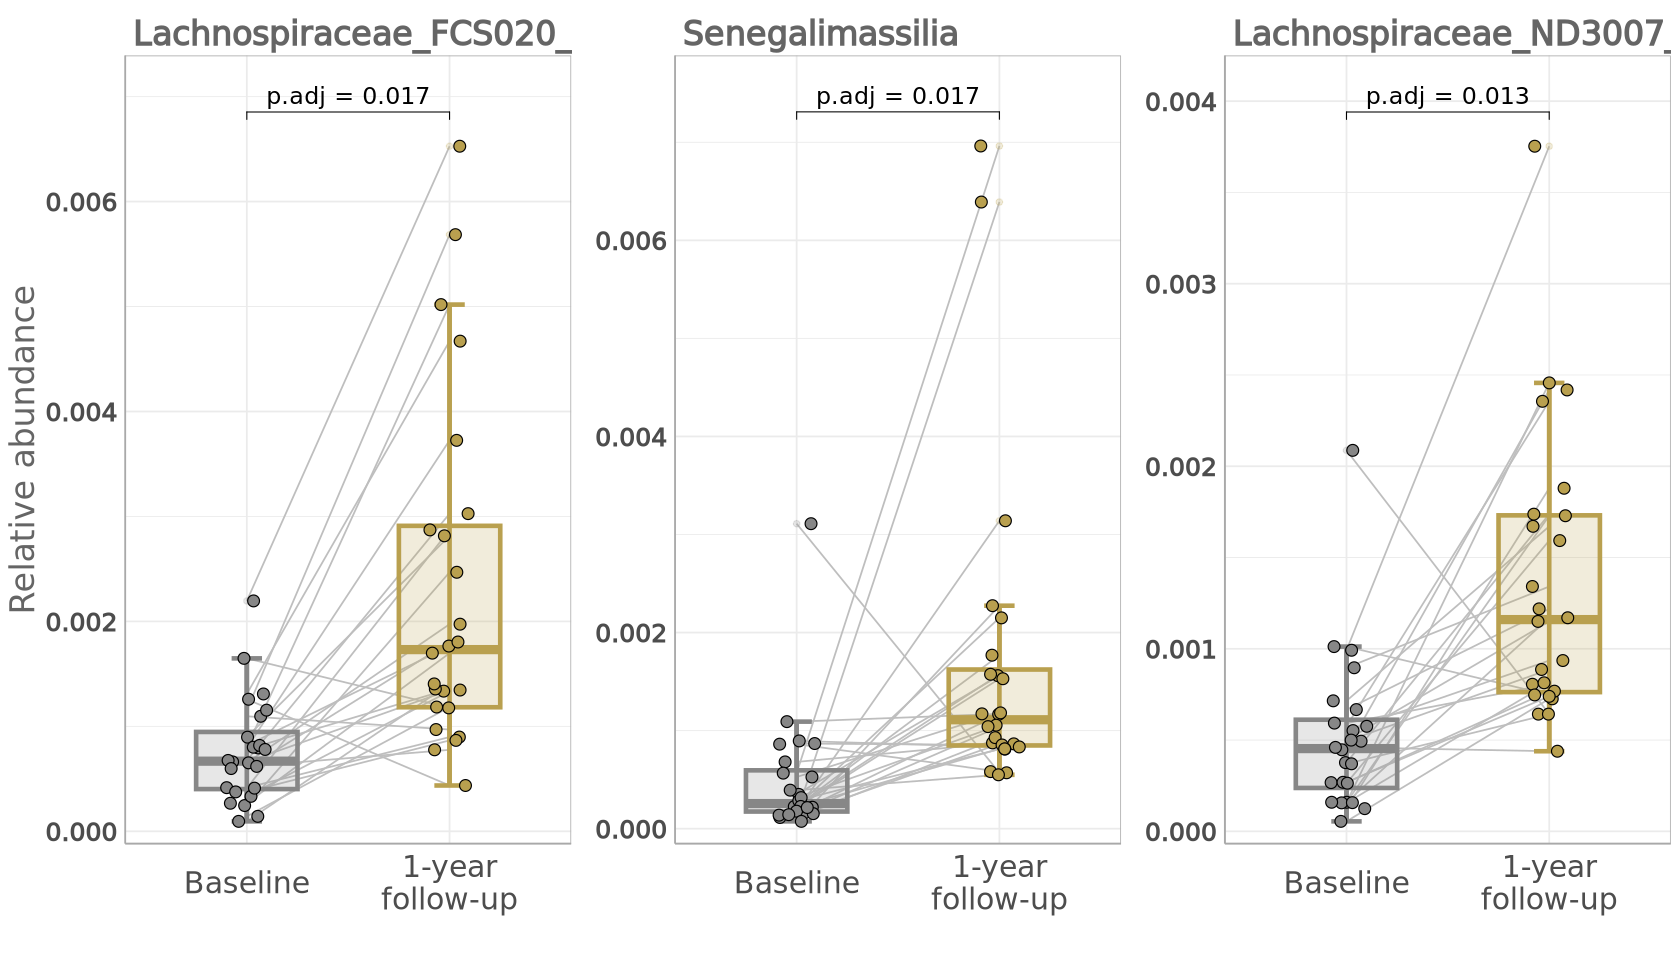

In [79]:
width = 14
height = 8
options(repr.plot.width=width, repr.plot.height=height)
comparisons <- list(c("Baseline", "1-year\nfollow-up"))

p <- ggplot(otu_data_boxplot) + 
# lines connecting pairs of samples
      geom_line(aes(x = grouping,  y=value, group = host_subject_id), color = "gray", linewidth = 0.5,) +
# plot error bar first
      stat_boxplot(aes(x=grouping, y=value, color = grouping), geom = "errorbar", width = 0.15, lwd=1.3) +
# lay boxplot on top
      geom_boxplot(aes(x=grouping, y=value, color = grouping, fill=grouping), alpha=0.2, lwd=1.3, width=0.5) +
# overlay alpha-diversity values as dots
      geom_jitter(aes(x=grouping, y=value, color = grouping, fill=grouping), 
                  size=3, width=0.1, shape=21, color='black')  + 
# add p-value statistics
      stat_pvalue_manual(data=test_pvalues, label='p.adj = {plabel}', label.size=5, tip.length=0.01) +  
# build a separate plot for each taxa
      facet_wrap(~variable, scales = "free_y", ncol=4) + 
# change default colors
      scale_fill_manual(values = c('#878787', '#b9a04f')) + 
# expand y limits to fit the p-value statistics into a plot
      scale_colour_manual(values = c('#878787', '#b9a04f')) +
# add titles
      labs(x = "", y = "Relative abundance") +
      scale_y_continuous(expand = expansion(mult = 0.03)) +
# ensure the maximum y axis limit is high enough to fit all the neccesary info 
      geom_blank(data = otu_data_max, aes(x = grouping, y=value, group = host_subject_id)) +
# custom plot design
      theme_minimal() +
      theme(axis.text=element_text(size=15),
            axis.title=element_text(size=20, face="bold"), 
            plot.title=element_text(size=24, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 20, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=18, angle=0, face='plain', vjust = 0.5, hjust=0.5),
            axis.title.y = element_text(color='#656565', face='plain'),
            text = element_text(size = 25, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(1, "lines"),
            legend.position="none", 
           ) 

k = 0.3
ggsave(file=file.path('../../results/figures', 'figure4', 'ALDEx2.Wilcoxon_test.STH.boxplots.top3.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
print(p)

In [80]:
# select all significant genera
aldex2_res_signif <- aldex2_res[aldex2_res$padj <= 0.05, ]
otu_data_boxplot <- otu_data[, aldex2_res_signif$lab]
otu_data_boxplot$grouping <- factor(metadata_aldex2$collection_timepoint, levels=c('baseline', 'follow-up'))
levels(otu_data_boxplot$grouping) <- c("Baseline", "1-year\nfollow-up")
otu_data_boxplot$host_subject_id <- metadata_aldex2$host_subject_id
otu_data_boxplot <- melt(otu_data_boxplot)

Using grouping, host_subject_id as id variables



In [81]:
test_pvalues <- aldex2_res_signif
test_pvalues$group1 <- "Baseline"
test_pvalues$group2 <- "1-year\nfollow-up"

test_pvalues$plabel <- format(test_pvalues$padj, fmt='e', digits=4)
test_pvalues$variable <- factor(test_pvalues$lab, levels=test_pvalues$lab)

otu_data_max <- filter(otu_data_boxplot, value==max(value), .by=variable)
max_y <- data.frame(value = otu_data_max$value*1.05, row.names=otu_data_max$variable)
test_pvalues$y.position <- max_y[test_pvalues$lab, 'value']
otu_data_max$value <- otu_data_max$value*1.1


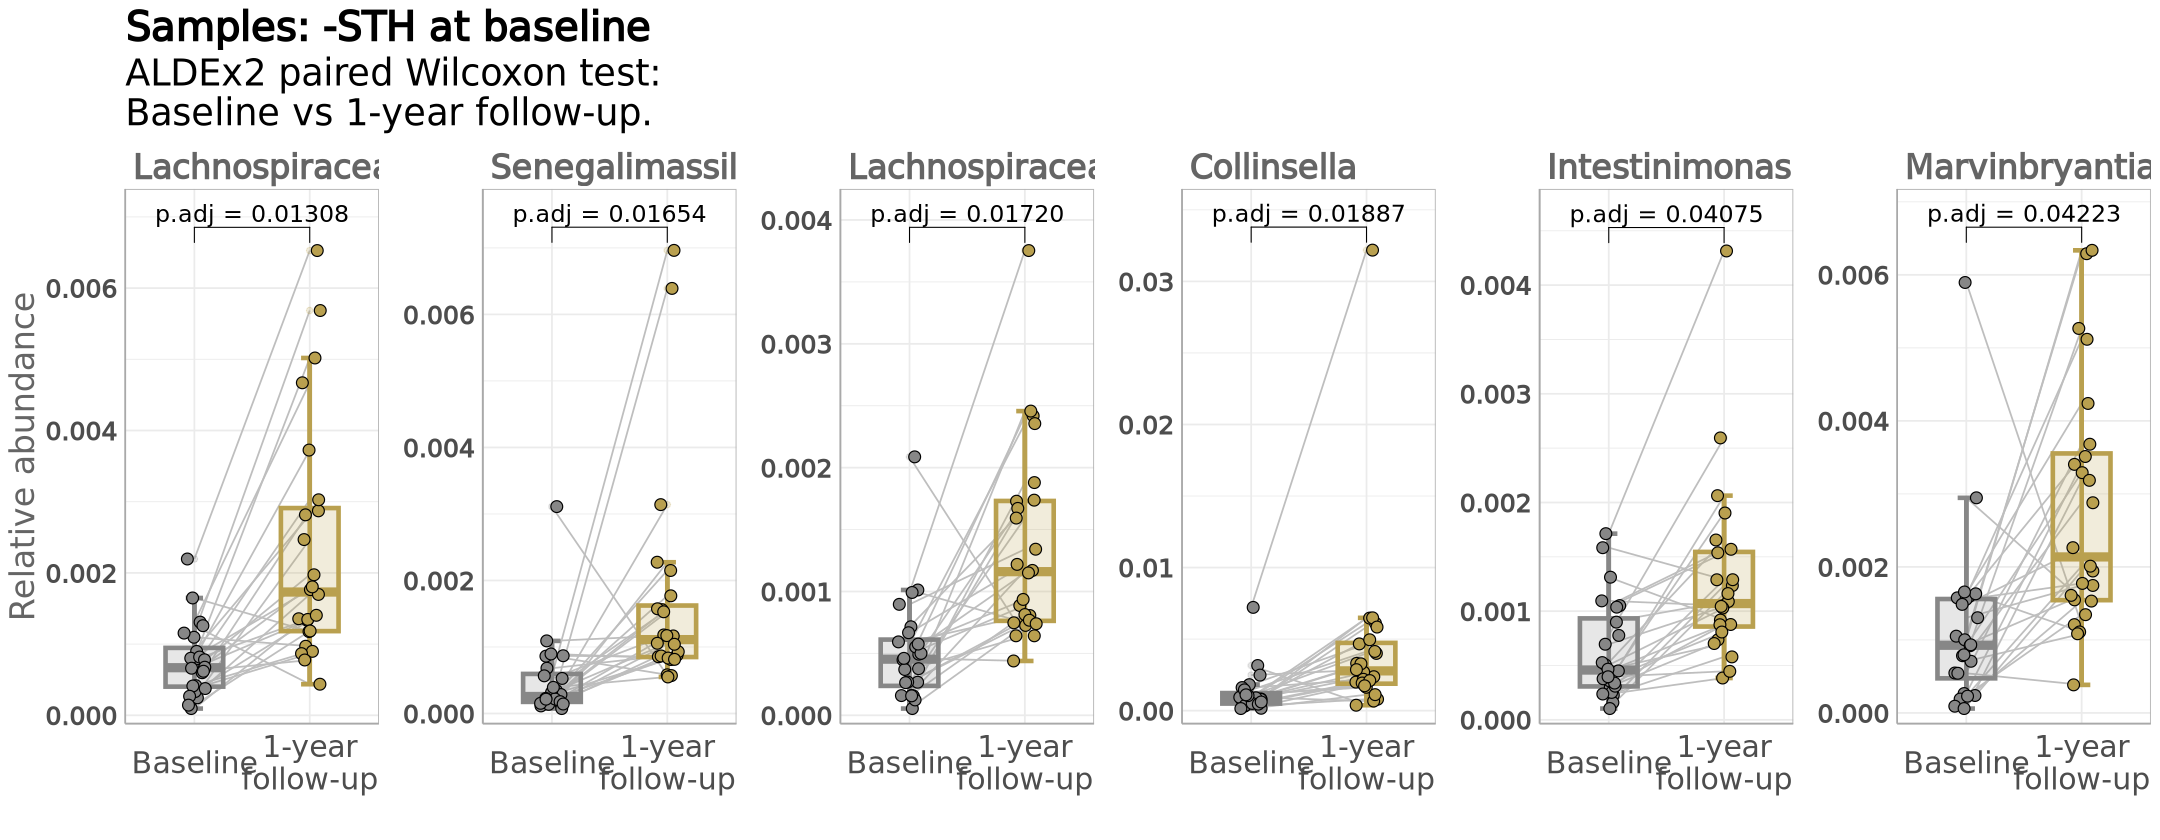

In [82]:
width = 18
height = 7
options(repr.plot.width=width, repr.plot.height=height)
comparisons <- list(c("Baseline", "1-year\nfollow-up"))

p <- ggplot(otu_data_boxplot) + 
# lines connecting pairs of samples
      geom_line(aes(x = grouping, y=value, group = host_subject_id), color = "gray", linewidth = 0.5,) +
# plot error bar first
      stat_boxplot(aes(x=grouping, y=value, color = grouping), geom = "errorbar", width = 0.15, lwd=1.3) +
# lay boxplot on top
      geom_boxplot(aes(x=grouping, y=value, color = grouping, fill=grouping), alpha=0.2, lwd=1.3, width=0.5) +
# overlay alpha-diversity values as dots
      geom_jitter(aes(x=grouping, y=value, color = grouping, fill=grouping), size=3, 
                  width=0.1, shape=21, color='black')  + 
# add p-value statistics
      stat_pvalue_manual(data=test_pvalues, label='p.adj = {plabel}', label.size=5, tip.length=0.03) +
# build a separate plot for each taxa
      facet_wrap(~variable, scales = "free_y", ncol=6) + 
# change default colors
      scale_fill_manual(values = c('#878787', '#b9a04f')) + 
      scale_colour_manual(values = c('#878787', '#b9a04f')) +
# add titles
      labs(x = "", y = "Relative abundance", title = "Samples: -STH at baseline",
           subtitle = "ALDEx2 paired Wilcoxon test:\nBaseline vs 1-year follow-up.") +
# expand y limits to fit the p-value statistics into a plot
      scale_y_continuous(expand = expansion(mult = 0.03)) +
# ensure the maximum y axis limit is high enough to fit all the neccesary info 
      geom_blank(data = otu_data_max, aes(x = grouping, y=value, group = host_subject_id)) +
# custom plot design
      theme_minimal() +
      theme(axis.text=element_text(size=15),
            axis.title=element_text(size=20, face="bold"), 
            plot.title=element_text(size=24, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 20, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=18, angle=0, face='plain', vjust = 0.5, hjust=0.5),
            axis.title.y = element_text(color='#656565', face='plain'),
            text = element_text(size = 25, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(1, "lines"),
            legend.position="none", 
           )
k = 0.3
ggsave(file=file.path('../../results/figures', 'supplementary_figure3', 
                      'ALDEx2.Wilcoxon_test.STH.boxplots.all.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
print(p)

# Save xlsx

In [83]:
p_values_summary_table <- list(All = p_values_summary_table_1, 
                               STH_negative = p_values_summary_table_2, 
                               STH_positive= p_values_summary_table_3)
write_xlsx(p_values_summary_table, file.path('../../results/tables', 'Table S1.ALDEx2.Wilcoxon_test.xlsx'))